# Error analysis on San Jose Census Block Groups

In [1]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, visualize_tile_predvOSM, assign_cbgs_by_coverage

In [2]:
import json
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
from pyproj import Geod
import rasterio
import rasterio.plot
from rasterio.transform import from_bounds
import rasterio.features
import seaborn as sns
import shapely
from shapely.geometry import box, Polygon
from shapely.ops import orient
from tqdm import tqdm

tqdm.pandas()

In [3]:
# Paths
TIF_FP = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020')
INFERENCES_DIR = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
IMG_FP = os.path.join(OAK_FP, 'san_jose_naip_512', 'phase2_superresx2')

In [49]:
# Params

# CF Round 1
N_CBGS = 20
N_CBG_TILES = 2
CBG_SAMPLING_TYPE = 'random'
N_EXTREME_TILES = 50

# CF Round 2
N_CBGS_R2 = 40

CF_ROUND = 2
assert CF_ROUND in [1, 2]

Functions (to be imported from other notebooks)

In [5]:
cbg_sj, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
building_footprints_infer = gpd.read_file(os.path.join(OUTPUT_FP, 'inference_building_processed'))
building_footprints_osm = gpd.read_file(os.path.join(OUTPUT_FP,'osm_building_processed'))
cbg_footprints = gpd.read_file(os.path.join(OUTPUT_FP, 'cbg_aggregate'))

[INFO] Restricting zoning data to R-1, R-2 and R-M (ex. R-MH)


## Functions

In [6]:
def get_error_masks(infer_tile, osm_tile):
    e_gdf = gpd.GeoDataFrame(geometry=[], crs='EPSG:4326')
    
    if len(infer_tile) == 0 and len(osm_tile) == 0:
        return e_gdf.copy(), e_gdf.copy(), e_gdf.copy(), e_gdf.copy()
    
    if len(infer_tile) == 0:
        false_pos = e_gdf.copy()
        false_neg = osm_tile.copy()
        FP_detached = e_gdf.copy()
        FP_attached = e_gdf.copy()
        return false_pos, false_neg, FP_detached, FP_attached
        
    # Explode multipolygons and remove Points
    infer_tile = infer_tile.explode(index_parts=True).reset_index(drop=True)
    infer_tile = infer_tile.loc[infer_tile.geometry.apply(lambda x: isinstance(x, shapely.geometry.polygon.Polygon))]
    
    if len(osm_tile) == 0:
        false_pos = infer_tile.copy()
        false_neg = e_gdf.copy()
        FP_detached = infer_tile.copy()
        FP_attached = e_gdf.copy()
        return false_pos, false_neg, FP_detached, FP_attached
        
    # "False positive" buildings (could be actual false positive or potentially small buildings not detected by OSM)
    false_pos = gpd.overlay(infer_tile[['geometry']], osm_tile[['geometry']], how='difference')

    # False negatives -- which are we missing
    false_neg = gpd.overlay(osm_tile[['geometry']], infer_tile[['geometry']], how='difference')

    # FP Detached buildings
    FP_detached = infer_tile.sjoin(osm_tile[['geometry']], how='left', predicate='intersects')
    FP_detached = FP_detached.loc[FP_detached.index_right.isna()]
    
    # Attachments
    if len(false_pos) == 0:
        FP_attached = e_gdf.copy()
    elif len(FP_detached) == 0:
        FP_attached = false_pos.copy()
    else:
        FP_attached = gpd.overlay(false_pos, FP_detached, how='difference')

    return false_pos, false_neg, FP_detached, FP_attached

In [7]:
def compute_tile_error(infer_tile, osm_tile):
    # Compute errors
    false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)
    
    # Handle masks with no polygons
    # Note: we add a negligible buffer to handle self-intersecting polygons
    B = 0.0000001
    false_pos_area = false_pos.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if false_pos.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    false_neg_area = false_neg.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if false_neg.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    FP_detached_area = FP_detached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if FP_detached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    FP_attached_area = FP_attached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union.area if FP_attached.to_crs('EPSG:26910').buffer(
        B).geometry.unary_union != None else 0
    
    # Save tile errors
    tile_error = {
        'false_pos_area': false_pos_area,
        'false_neg_area': false_neg_area,
        'FP_detached_area': FP_detached_area,
        'FP_attached_area': FP_attached_area
    }

    # Normalize by total built area (per OSM)
    if len(osm_tile) == 0:
        for key in list(tile_error.keys()):
            tile_error[key.replace('area', 'perc')] = None
    else:
        tile_built_area = osm_tile.to_crs('EPSG:26910').geometry.unary_union.area
        for key in list(tile_error.keys()):
            tile_error[key.replace('area', 'perc')] = tile_error[key] / tile_built_area * 100
    
    return tile_error

In [8]:
def visualize_tile_only(file):
    raster = rasterio.open(os.path.join(TIF_FP, '{}.tif'.format(file)))
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    rasterio.plot.show(raster, ax=ax)
    plt.show()

In [9]:
def visualize_tile_full(fn):
    tile_bounds = get_bounds(tile_bounds_dict, fn)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    zone_tile = gpd.clip(zoning, tile_bounds)

    raster = rasterio.open(os.path.join(TIF_FP, '{}.tif'.format(fn)))

    plt.clf()
    fig, ax = plt.subplots(figsize=(4, 4))
    rasterio.plot.show(raster, ax=ax, transform=t)
    zone_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='black', alpha=0.5)
    osm_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue')
    infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='red', alpha=0.5)
    plt.show()

## Compute errors for all tiles

In [10]:
with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
    tile_bounds_dict = json.load(f)

In [12]:
# Get tiles
tiles = glob.glob(os.path.join(INFERENCES_DIR, '*.npy'))
tiles = [t.split(os.path.sep)[-1].replace('.npy', '') for t in tiles]

# Compute errors for all tiles
tile_metrics_fp = os.path.join(OUTPUT_FP, 'Error-Analysis', 'tile-metrics-df.csv')
if os.path.exists(tile_metrics_fp):
    tile_metrics_pd = pd.read_csv(tile_metrics_fp)
    computed_tiles = tile_metrics_pd['file'].unique()
    tiles = set(tiles).difference(set(computed_tiles))
    tiles = list(tiles)
else:
    tile_metrics_pd = pd.DataFrame()

print('[INFO] Computing tile errors for {} tiles'.format(len(tiles)))
for i, file_name in tqdm(enumerate(tiles)):
    # Compute tile errors
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    tile_error = compute_tile_error(infer_tile, osm_tile)
    
    # Append to DataFrame
    tile_error = pd.DataFrame.from_dict({k: [v] for k, v in tile_error.items()})
    tile_error['file'] = [file_name]
    tile_metrics_pd = pd.concat([tile_metrics_pd, tile_error])
    
    # Save progress
    if i % 50 == 0 or i == len(tiles) - 1:
        tile_metrics_pd.to_csv(tile_metrics_fp, index=False)

[INFO] Computing tile errors for 0 tiles


0it [00:00, ?it/s]


## Stratified Random Sampling

In [13]:
# Stratify by CBG
tile_metrics_pd  = pd.read_csv(tile_metrics_fp)

tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
    lambda name: get_bounds(tile_bounds_dict, name)
)

100%|██████████| 3074/3074 [00:00<00:00, 51726.89it/s]


In [14]:
tile_metrics_pd = gpd.GeoDataFrame(tile_metrics_pd, crs='EPSG:4326')
assert tile_metrics_pd.crs == cbg_sj.crs

In [15]:
# SJoin by cbg with most overlap
tile_metrics_cbg = assign_cbgs_by_coverage(tile_metrics_pd, cbg_sj)

# Verify we have all the original tiles (once)
assert len(tile_metrics_cbg.file) == len(tile_metrics_pd.file)

# Visualize tile overlap
#fig, ax = plt.subplots(figsize=(15, 15))
#tile_metrics_pd.plot(edgecolor='black', facecolor='white', ax=ax)
#cbg_sj.plot(edgecolor='red', facecolor='none', ax=ax)
#plt.show()

100%|██████████| 7265/7265 [00:10<00:00, 678.97it/s]


In [16]:
# Keep only statistics for small buildings
cbg_footprints = cbg_footprints.loc[cbg_footprints.small == 1]

# Drop CBGs with missing OSM data
cbg_footprints = cbg_footprints.loc[~cbg_footprints.b_n_osm.isna()]

In [17]:
# Get tiles for each CBG
cbg_tiles = tile_metrics_cbg.groupby('GEOID')['file'].unique().to_frame().reset_index()
cbg_footprints = cbg_footprints.merge(cbg_tiles, how='left')

In [35]:
# Select CBGs
if CBG_SAMPLING_TYPE == 'residuals':
    # Identify CBGs with highest residuals (for stratification)
    cbg_footprints['b_n_resi'] = cbg_footprints['b_n_inf'] - cbg_footprints['b_n_osm']
    cbg_footprints.sort_values(by='b_n_resi', inplace=True)

    # Grab bottom and top N_CBGS
    cbg_footprints_sampled = pd.concat([cbg_footprints.head(N_CBGS), cbg_footprints.tail(N_CBGS)])
elif CBG_SAMPLING_TYPE == 'random':
    # Round 1
    np.random.seed(42)
    selected_cbgs = np.random.choice(list(range(len(cbg_footprints))), size=N_CBGS * 2, replace=False)
    cbg_footprints_sampled = cbg_footprints.iloc[selected_cbgs].copy()
    
    if CF_ROUND == 2:
        # Round 2
        np.random.seed(42)
        remaining_cbgs = set(range(len(cbg_footprints))).difference(set(selected_cbgs))
        selected_cbgs_R2 = np.random.choice(list(remaining_cbgs), size=int(N_CBGS_R2 * 2), replace=False)
        cbg_footprints_sampled =  cbg_footprints.iloc[selected_cbgs_R2].copy()

In [36]:
np.random.seed(42)
# Sample tiles from selected CBGs
cbg_footprints_sampled['sampled_tiles'] = cbg_footprints_sampled['file'].apply(
    lambda tile_list: None if pd.isna([tile_list]).sum() else np.random.choice(
        tile_list, size=N_CBG_TILES if len(tile_list) >= N_CBG_TILES else 1, replace=False))

In [38]:
# Add sampled tiles to main DF
tile_metrics_cbg['sampled'] = tile_metrics_cbg['file'].isin(cbg_footprints_sampled['sampled_tiles'].explode().to_numpy())
print('Sampled tiles: {}'.format(tile_metrics_cbg['sampled'].sum()))

# Add sampling rationale
tile_metrics_cbg['sample_rationale'] = tile_metrics_cbg['sampled'].apply(
    lambda x: 'CBG' if x == 1 else None)

Sampled tiles: 152


In [39]:
# Get tile OSM building area
tile_build_area = tile_metrics_cbg[['file', 'geometry']].sjoin(
    building_footprints_osm[['area', 'geometry']], predicate='intersects', how='right')
tile_build_area = tile_build_area.groupby('file')['area'].sum().reset_index()

tile_metrics_cbg = tile_metrics_cbg.merge(tile_build_area[['file', 'area']], on='file', how='left')

# Assign a zero area value for tiles with missing area (as there are no OSM buildings here)
tile_metrics_cbg['area'] = tile_metrics_cbg['area'].fillna(value=0)
tile_metrics_cbg = tile_metrics_cbg.rename(columns={'area': 'osm_area'})

In [ ]:
#tile_metrics_cbg['osm_area'].hist()
#plt.show()

In [40]:
if CF_ROUND == 1:
    # Sample tiles with extreme FP or FN values
    # Note: Use a minimum threshold area.
    # Tiles with relevant building area have areas approx. >= 4k
    osm_build_threshold = 4000

    tile_metrics_cbg_FN = tile_metrics_cbg.loc[tile_metrics_cbg['osm_area'] > osm_build_threshold].sort_values(
        by='false_neg_perc', inplace=False)
    tile_metrics_cbg_FN = tile_metrics_cbg_FN.tail(N_EXTREME_TILES // 2)

    tile_metrics_cbg_FP = tile_metrics_cbg.loc[tile_metrics_cbg['osm_area'] > osm_build_threshold].sort_values(
        by='false_pos_perc', inplace=False)
    tile_metrics_cbg_FP = tile_metrics_cbg_FP.tail(N_EXTREME_TILES // 2)

    FP_FN_tiles = set(tile_metrics_cbg_FP['file']).union(set(tile_metrics_cbg_FN['file']))
    
    # Mark chosen tiles
    tile_metrics_cbg['sampled'] = tile_metrics_cbg.apply(
        lambda x: 1 if x['sampled'] == True else x['file'] in(FP_FN_tiles), axis=1)

    # Add sampling rationale
    tile_metrics_cbg['sample_rationale'] = tile_metrics_cbg.apply(
        lambda x: 'Extremes' if x['file'] in FP_FN_tiles else x['sample_rationale'], axis=1)

    print('Sampled tiles: {}'.format(tile_metrics_cbg['sampled'].sum()))

In [41]:
sampled_tiles = tile_metrics_cbg.loc[tile_metrics_cbg['sampled'] == True].copy()

In [44]:
# Add building information to each tile
def get_num_buildings(file_name):
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    
    # Get small OSM & Inference buildings
    infer_tile_small = infer_tile.loc[infer_tile.small == 1]
    osm_tile_small = osm_tile.loc[osm_tile.small == 1]
    
    # Get polygon centroids for inferred buildings
    centroids = infer_tile_small['geometry'].apply(lambda geom: list(geom.centroid.coords))
    
    return pd.Series([len(infer_tile_small), len(osm_tile_small), centroids.to_list()])

In [48]:
if CF_ROUND == 1:
    sampled_tiles[['n_infer', 'n_osm', 'list_infer']] = sampled_tiles.progress_apply(
        lambda x: get_num_buildings(x['file']), axis=1)
    
    # Save csv file
    sampled_tiles[['file', 'GEOID', 'sample_rationale', 'false_pos_area', 'false_neg_area',
           'FP_detached_area', 'FP_attached_area', 'false_pos_perc',
           'false_neg_perc', 'FP_detached_perc', 'FP_attached_perc',
           'n_infer', 'n_osm', 'list_infer']].to_csv(os.path.join(OUTPUT_FP, 'Error-Analysis', 'sampled_tiles.csv'), index=False)
    
elif CF_ROUND == 2:
    sampled_tiles[['file', 'GEOID', 'sample_rationale', 'false_pos_area', 'false_neg_area',
           'FP_detached_area', 'FP_attached_area', 'false_pos_perc',
           'false_neg_perc', 'FP_detached_perc', 'FP_attached_perc']].to_csv(
        os.path.join(OUTPUT_FP, '..', 'Temporal-Error-Analysis', 'Round2', 'sampled_tiles.csv'), index=False)

In [32]:
# Generate visualizations
_ = sampled_tiles['file'].progress_apply(lambda file_name: visualize_tile_predvOSM(
    tile_bounds_dict=tile_bounds_dict, building_footprints_infer=building_footprints_infer, 
    building_footprints_osm=building_footprints_osm,
    file_name=file_name, img_fp=IMG_FP,
    tif_fp=TIF_FP, final_output_fp=os.path.join(OUTPUT_FP, 'Error-Analysis', 'Visualizations'),
    save=True))

  9%|▊         | 10/117 [02:40<31:17, 17.55s/it]<ipython-input-16-9d3f0db392ed>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 15))
100%|██████████| 117/117 [43:22<00:00, 22.25s/it] 


## Get error stats from checked tiles

In [6]:
checked_tiles = pd.read_csv(os.path.join(OUTPUT_FP, 'Error-Analysis', 'sampled_tiles_checked.csv'))

In [8]:
checked_tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   file                                 117 non-null    object 
 1   GEOID                                117 non-null    int64  
 2   sample_rationale                     117 non-null    object 
 3   false_pos_area                       117 non-null    float64
 4   false_neg_area                       117 non-null    float64
 5   FP_detached_area                     117 non-null    float64
 6   FP_attached_area                     117 non-null    float64
 7   false_pos_perc                       111 non-null    float64
 8   false_neg_perc                       111 non-null    float64
 9   FP_detached_perc                     111 non-null    float64
 10  FP_attached_perc                     111 non-null    float64
 11  n_infer(small)                  

In [9]:
# Filter for tiles (CBG or Extremes) that have been checked
checked_tiles = checked_tiles.loc[~checked_tiles['n_infer(small)_groundTruth'].isna()]

In [10]:
# Get ground truth small buildings in tile
# Total ground truth small buildings should be correctly predicted + missed, which may or may not
# equal the number of small buildings in OSM
checked_tiles['n_GT_small'] = checked_tiles['n_infer(small)_groundTruth'] + checked_tiles['n_GT_missed(small)']

In [11]:
# Compute metrics
checked_tiles['n_FP'] = checked_tiles['n_infer(small)'] - checked_tiles['n_infer(small)_groundTruth']
checked_tiles['n_TP'] = checked_tiles['n_infer(small)_groundTruth']
checked_tiles['n_FN'] = checked_tiles['n_GT_missed(small)']

In [12]:
# Recall and precision
checked_tiles['recall'] = checked_tiles.apply(
    lambda row: row['n_TP'] / (row['n_TP'] + row['n_FN']) if row['n_TP'] + row['n_FN'] > 0 else None, axis=1)
checked_tiles['precision'] = checked_tiles.apply(
    lambda row: row['n_TP'] / (row['n_TP'] + row['n_FP']) if row['n_TP'] + row['n_FP'] > 0 else None, axis=1)

Recall
count    29.000000
mean      0.659628
std       0.222988
min       0.000000
25%       0.605263
50%       0.708333
75%       0.800000
max       1.000000
Name: recall, dtype: float64


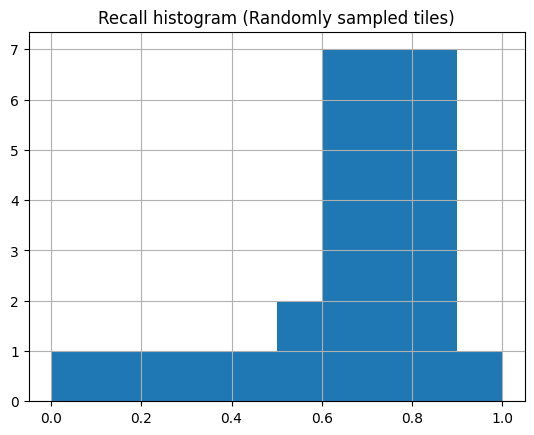

Precision
count    30.000000
mean      0.544862
std       0.217035
min       0.000000
25%       0.454781
50%       0.595455
75%       0.688312
max       0.821429
Name: precision, dtype: float64


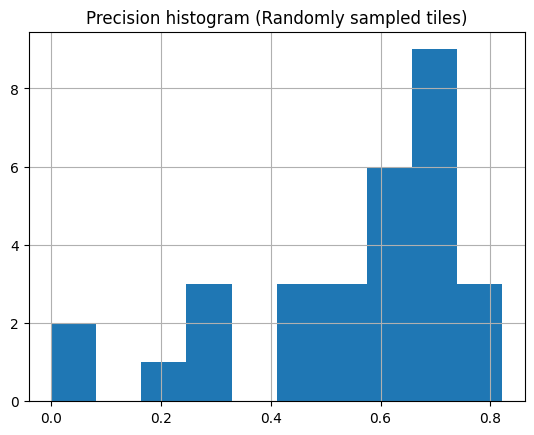

In [13]:
# Stats for randomly sampled tiles
checked_tiles_rsampled = checked_tiles.loc[checked_tiles['sample_rationale'] == 'CBG']

# Recall
print('Recall')
print(checked_tiles_rsampled['recall'].describe())
checked_tiles_rsampled['recall'].hist()
plt.title('Recall histogram (Randomly sampled tiles)')
plt.show()

# Precision
print('Precision')
print(checked_tiles_rsampled['precision'].describe())
checked_tiles_rsampled['precision'].hist()
plt.title('Precision histogram (Randomly sampled tiles)')
plt.show()

Recall
count    38.000000
mean      0.705101
std       0.220801
min       0.000000
25%       0.646875
50%       0.751623
75%       0.831522
max       1.000000
Name: recall, dtype: float64


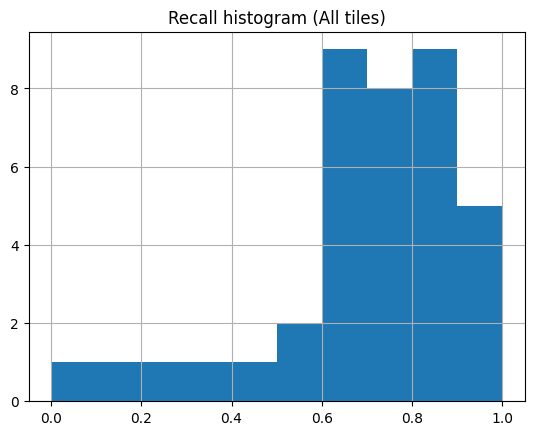

Precision
count    39.000000
mean      0.527408
std       0.216136
min       0.000000
25%       0.457949
50%       0.586207
75%       0.677866
max       0.821429
Name: precision, dtype: float64


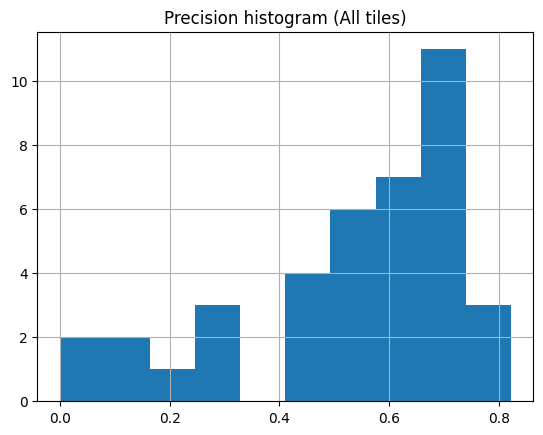

In [14]:
# Stats for all tiles
# Recall
print('Recall')
print(checked_tiles['recall'].describe())
checked_tiles['recall'].hist()
plt.title('Recall histogram (All tiles)')
plt.show()

# Precision
print('Precision')
print(checked_tiles['precision'].describe())
checked_tiles['precision'].hist()
plt.title('Precision histogram (All tiles)')
plt.show()

21


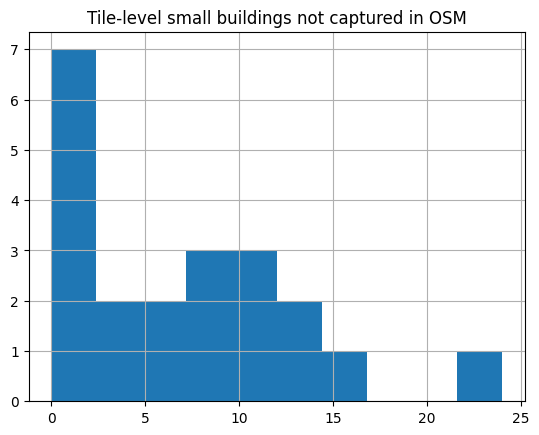

In [21]:
# Buildings not captured by OSM
print(len(checked_tiles_rsampled) - checked_tiles_rsampled['n_GT_missedOSM(small)'].isna().sum())
checked_tiles_rsampled['n_GT_missedOSM(small)'].hist()
plt.title('Tile-level small buildings not captured in OSM')
plt.show()

In [15]:
checked_tiles.sort_values('recall').head()

file        GEOID sample_rationale  \
58  m_3712142_nw_10_060_20200525_270  60855035041              CBG   
59  m_3712141_se_10_060_20200525_473  60855029101              CBG   
60  m_3712142_nw_10_060_20200525_314  60855035044              CBG   
81  m_3712141_se_10_060_20200525_407  60855029083              CBG   
21  m_3712134_sw_10_060_20200525_245  60855043153              CBG   

    false_pos_area  false_neg_area  FP_detached_area  FP_attached_area  \
58      300.731069      175.754170         40.410205        260.320865   
59     1418.138182     1278.293472        145.100441       1273.037741   
60     5768.830109     1614.041969       1941.955123       3826.874987   
81     1868.848590     2694.662025        323.276267       1545.572324   
21     2367.087128     2682.814084        221.487649       2145.599480   

    false_pos_perc  false_neg_perc  FP_detached_perc  ...  \
58       22.086105       12.907629          2.967781  ...   
59        8.827770        7.957250          0.903236  ...   
60       29.798546        8.337237         10.031053  ...   
81        7.746166       11.169070          1.339944  ...   
21       11.702608       13.263526          1.095010  ...   

                                                Notes  \
58                                                NaN   
59  OSM marks 4 small buildings that weren't captu...   
60  High FN/FP area driven by the presence of a st...   
81                         Confusion with trampolines   
21       some basketball fields producing a lot of FP   

    n_infer(small)_groundTruth_2ndcheck  n_GT_missed(small)_2ndcheck  \
58                                  NaN                          NaN   
59                                  3.0                          2.0   
60                                  NaN                          NaN   
81                                  NaN                          NaN   
21                                  4.0                          5.0   

   n_GT_missedOSM(small)_2ndcheck n_GT_small  n_FP  n_TP  n_FN    recall  \
58                            NaN        3.0   4.0   0.0   3.0  0.000000   
59                            NaN       17.0   7.0   3.0  14.0  0.176471   
60                            NaN       50.0  31.0  13.0  37.0  0.260000   
81                            NaN       34.0  17.0  13.0  21.0  0.382353   
21                            NaN        9.0  19.0   4.0   5.0  0.444444   

    precision  
58   0.000000  
59   0.300000  
60   0.295455  
81   0.433333  
21   0.173913  

[5 rows x 28 columns]

# Extend to 2016 and 2018

In [6]:
# Paths
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
TIF_FP = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/raw_tif', 
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/raw_tif',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
}

INFERENCES_DIR = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/infer',
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/infer',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
}
IMG_FP = {
    '2016': os.path.join(OAK_FP, 'san_jose_naip_512', '2016', 'superresx2'),
    '2018': os.path.join(OAK_FP, 'san_jose_naip_512', '2018', 'superresx2'),
    '2020': os.path.join(OAK_FP, 'san_jose_naip_512', 'phase2_superresx2')
}


YEARS = ['2016', '2018', '2020']
TEMPORAL_OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Temporal-Error-Analysis')

In [7]:
# Load tile dict for each year
tile_bounds_dict_all = {}
for year in ['2016', '2018', '2020']:
    OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}'.format(year))
    with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
        tile_bounds_dict = json.load(f)
        tile_bounds_dict_all[year] = tile_bounds_dict

In [8]:
# Load inferred buildings for all years
building_footprints_infer = {}
for year in YEARS:
    building_footprints_infer[year] = gpd.read_file(os.path.join(OAK_FP, 'outputs/cbg-inference-{}/inference_building_processed'.format(year)))

In [9]:
# Get tiles for all years
tiles_gdf = {}
for year in YEARS:
    tiles = glob.glob(os.path.join(INFERENCES_DIR[year], '*.npy'))
    tiles = [t.split(os.path.sep)[-1].replace('.npy', '') for t in tiles]
    tile_metrics_pd = pd.DataFrame(tiles, columns=['file'])

    tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
        lambda name: get_bounds(tile_bounds_dict_all[year], name) if name in list(tile_bounds_dict_all[year].keys()) else None
    )
    tiles_gdf[year] = gpd.GeoDataFrame(tile_metrics_pd.copy(), crs='EPSG:4326')

100%|██████████| 3074/3074 [00:00<00:00, 18420.93it/s]


In [10]:
# Load checked tiles and filter for CBG tiles that have been checked
checked_tiles = pd.read_csv(os.path.join(OUTPUT_FP, 'Error-Analysis', 'sampled_tiles_checked.csv'))
checked_tiles = checked_tiles.loc[~checked_tiles['n_infer(small)_groundTruth'].isna()]
checked_tiles = checked_tiles.loc[checked_tiles['sample_rationale'] == 'CBG']

In [11]:
# Get sampled 2020 tile names
checked_2020_tiles = list(checked_tiles['file'].unique())

In [12]:
# Build df of 2016, 2018, 2020 cropped tiles
rename_cols = ['file', 'n_infer(small)', 'n_infer(small)', 'list_infer(small)', 
    'n_infer(small)_groundTruth', 'n_GT_missed(small)', 'n_GT_missedOSM(small)']
temporal_tiles = checked_tiles[rename_cols + ['GEOID']].copy()
temporal_tiles.rename(columns={c: '{}_2020'.format(c) for c in rename_cols}, inplace=True)

In [13]:
# Find corresponding 2016 and 2018 tiles and crop all to intersection
temporal_tiles['geometry'] = temporal_tiles.file_2020.progress_apply(
        lambda name: get_bounds(tile_bounds_dict_all['2020'], name) if name in list(tile_bounds_dict_all['2020'].keys()) else None
)
temporal_tiles = gpd.GeoDataFrame(temporal_tiles, crs='EPSG:4326')

100%|██████████| 33/33 [00:00<00:00, 11894.13it/s]


In [14]:
for year in ['2016', '2018']:
    temporal_tiles = gpd.sjoin(
            tiles_gdf[year][['file', 'geometry']], temporal_tiles, 
            how='right', predicate='intersects')

    temporal_tiles['intersection'] = temporal_tiles.progress_apply(
        lambda x: x['geometry'].intersection(tiles_gdf[year].loc[tiles_gdf[year]['file'] == x['file']].iloc[0]['geometry']).area,
        axis=1)

    temporal_tiles = temporal_tiles.sort_values(by='intersection')

    temporal_tiles.drop_duplicates(inplace=True, subset='geometry', keep='last')
    temporal_tiles.drop('intersection', axis=1, inplace=True)
    temporal_tiles.rename(columns={'file': 'file_{}'.format(year)}, inplace=True)
    temporal_tiles.drop('index_left', axis=1, inplace=True)

100%|██████████| 142/142 [00:00<00:00, 646.25it/s]


In [15]:
# Generate geometry that is tile intersection
def get_temporal_tile_intersection(annual_dict):
    # Get the 3 geometries
    tile_int_bounds = Polygon(tile_bounds_dict_all['2020'][annual_dict['2020']])

    for year in ['2016', '2016']:
        tile_year_bounds = Polygon(tile_bounds_dict_all[year][annual_dict[year]])
        tile_int_bounds = tile_int_bounds.intersection(tile_year_bounds)
    return tile_int_bounds   
    
temporal_tiles['geometry'] = temporal_tiles.progress_apply(
    lambda row: get_temporal_tile_intersection(
        {'2016': row['file_2016'], '2018': row['file_2018'], '2020': row['file_2020']}
        ), axis=1)

100%|██████████| 33/33 [00:00<00:00, 3485.92it/s]


In [56]:
# Generate visualizations for all three years including OSM and model inferences

for year in ['2016', '2018', '2020']:
    _ = temporal_tiles.to_crs('EPSG:26910').progress_apply(lambda row: visualize_tile_predvOSM(
        tile_bounds_dict=tile_bounds_dict_all[year], 
        building_footprints_infer=building_footprints_infer[year], 
        building_footprints_osm=building_footprints_osm,
        file_name=row['file_{}'.format(year)], 
        img_fp=IMG_FP[year],
        tif_fp=TIF_FP[year], 
        final_output_fp=os.path.join(TEMPORAL_OUTPUT_FP, 'Visualizations'),
        save=True, small=True, cropping=gpd.GeoDataFrame(geometry=[row['geometry']], crs='EPSG:26910')), axis=1)

100%|██████████| 33/33 [10:24<00:00, 18.92s/it]


In [55]:
# Save to file
temporal_tiles[['file_2016', 'file_2018', 'file_2020', 'n_infer(small)_2020', 
                'n_infer(small)_2020', 'list_infer(small)_2020', 
                'n_infer(small)_groundTruth_2020', 'n_GT_missed(small)_2020', 
                'n_GT_missedOSM(small)_2020']].to_csv(
    os.path.join(TEMPORAL_OUTPUT_FP, 'sampled_temporal_tiles.csv'), index=False)

In [47]:
file_name = 'm_3712141_se_10_060_20180725_158'
cropping = temporal_tiles.to_crs('EPSG:26910').iloc[0]['geometry']
tile_bounds = Polygon(get_bounds(tile_bounds_dict_all['2018'], file_name))


In [48]:
black_poly = tile_bounds.difference(cropping)

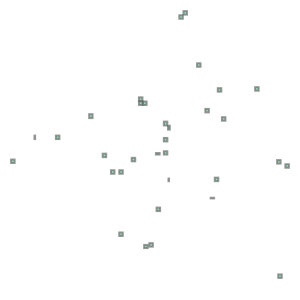

In [50]:
temporal_tiles.to_crs('EPSG:26910').geometry.unary_union

In [85]:
file_name = 'm_3712141_se_10_h_20160529_158'
tif_fp = TIF_FP['2016']
img_file = None
for dirname in ['train', 'val', 'test']:
    dirpath = os.path.join(IMG_FP['2016'], dirname, 'images', '{}.npy'.format(file_name))
    if os.path.exists(dirpath):
        img_file = dirpath

tile_img = np.load(img_file)
raster = rasterio.open(os.path.join(tif_fp, '{}.tif'.format(file_name)))
t = from_bounds(*raster.bounds, tile_img.shape[0], tile_img.shape[1])

# Crop to a specified geometry
cropping = temporal_tiles.to_crs('EPSG:26910').iloc[0]['geometry']
if cropping:
    raster, t = rasterio.mask.mask(raster, [cropping], crop=True)


In [37]:
temporal_tiles.head(10)

file_2018                       file_2016  \
23  m_3712141_se_10_060_20180725_158  m_3712141_se_10_h_20160529_158   
0   m_3712141_nw_10_060_20180725_384  m_3712141_nw_10_h_20160529_384   
6   m_3712142_sw_10_060_20180725_231  m_3712142_sw_10_h_20160527_231   
7   m_3712141_ne_10_060_20180725_476  m_3712141_ne_10_h_20160529_476   
4   m_3712142_nw_10_060_20180725_341  m_3712142_nw_10_h_20160527_341   
59  m_3712141_se_10_060_20180725_473  m_3712141_se_10_h_20160529_473   
26  m_3712141_ne_10_060_20180725_478  m_3712141_ne_10_h_20160529_478   
64  m_3712150_ne_10_060_20180725_169  m_3712150_ne_10_h_20160527_169   
35   m_3712149_ne_10_060_20180725_14   m_3712149_ne_10_h_20160529_14   
81  m_3712141_se_10_060_20180725_407  m_3712141_se_10_h_20160529_407   

                           file_2020  n_infer(small)_2020  \
23  m_3712142_sw_10_060_20200525_141                    6   
0   m_3712141_nw_10_060_20200525_385                    0   
6   m_3712142_sw_10_060_20200525_251                    0   
7    m_3712141_se_10_060_20200525_36                    0   
4   m_3712141_ne_10_060_20200525_359                   28   
59  m_3712141_se_10_060_20200525_473                   10   
26  m_3712141_ne_10_060_20200525_478                   74   
64  m_3712150_ne_10_060_20200525_169                   29   
35   m_3712149_ne_10_060_20200525_14                   21   
81  m_3712141_se_10_060_20200525_407                   30   

    n_infer(small)_2020                             list_infer(small)_2020  \
23                    6  [[(-121.87356276186199, 37.29272398767845)], [...   
0                     0                                                 []   
6                     0                                                 []   
7                     0                                                 []   
4                    28  [[(-121.87326994548212, 37.329435842327754)], ...   
59                   10  [[(-121.89549525250106, 37.248103677352205)], ...   
26                   74  [[(-121.87525782495797, 37.312265676595835)], ...   
64                   29  [[(-121.78188752988548, 37.22954120314965)], [...   
35                   21  [[(-121.88822886336953, 37.25117373249891)], [...   
81                   30  [[(-121.91402001010835, 37.25881631981568)], [...   

    n_infer(small)_groundTruth_2020  n_GT_missed(small)_2020  \
23                              0.0                      0.0   
0                               0.0                      0.0   
6                               0.0                      0.0   
7                               0.0                      0.0   
4                              23.0                      8.0   
59                              3.0                     14.0   
26                             40.0                     12.0   
64                             17.0                      7.0   
35                              6.0                      3.0   
81                             13.0                     21.0   

    n_GT_missedOSM(small)_2020        GEOID  \
23                         NaN  60855031272   
0                          0.0  60855062033   
6                          0.0  60855031272   
7                          0.0  60855031212   
4                          2.0  60855016023   
59                        12.0  60855029101   
26                         NaN  60855031212   
64                         8.0  60855120321   
35                         4.0  60855029101   
81                        24.0  60855029083   

                                             geometry  
23  POLYGON ((-121.87404 37.29449, -121.87360 37.2...  
0   POLYGON ((-121.98562 37.32419, -121.98508 37.3...  
6   POLYGON ((-121.83613 37.28087, -121.83905 37.2...  
7   POLYGON ((-121.88116 37.31160, -121.88117 37.3...  
4   POLYGON ((-121.87249 37.32712, -121.87396 37.3...  
59  POLYGON ((-121.89507 37.24825, -121.89504 37.2...  
26  POLYGON ((-121.87770 37.31055, -121.87767 37.3...  
64  POLYGON ((-121.78343 37.2272

<Figure size 640x480 with 0 Axes>

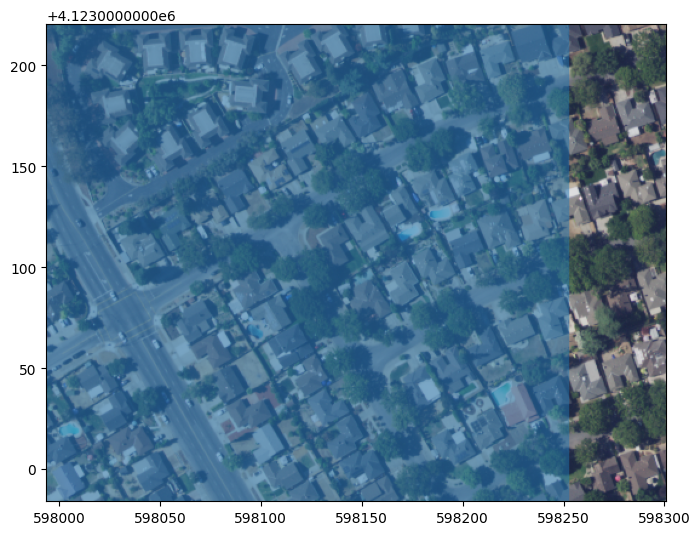

In [40]:
year = '2018'
file = 'm_3712141_se_10_060_20180725_473'
raster = rasterio.open(os.path.join(TIF_FP[year], '{}.tif'.format(file)))
plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show(raster, ax=ax)
temporal_tiles.iloc[[5]].to_crs('EPSG:26910').plot(ax=ax, alpha=0.5)
plt.show()

In [42]:
year = '2018'
file = 'm_3712141_se_10_060_20180725_473'

img_file = None
for dirname in ['train', 'val', 'test']:
    dirpath = os.path.join(IMG_FP[year], dirname, 'images', '{}.npy'.format(file))
    if os.path.exists(dirpath):
        img_file = dirpath
tile_img = np.load(img_file)

raster = rasterio.open(os.path.join(TIF_FP[year], '{}.tif'.format(file)))
t = from_bounds(*raster.bounds, tile_img.shape[0], tile_img.shape[1])
cropping = temporal_tiles.to_crs('EPSG:26910').iloc[[5]]['geometry']
raster, t = rasterio.mask.mask(raster, [cropping], crop=True)
    

plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
#rasterio.plot.show(raster, ax=ax)
rasterio.plot.show(np.moveaxis(tile_img, 2, 0),transform=t, ax=ax)
temporal_tiles.iloc[[5]].to_crs('EPSG:26910').plot(ax=ax)
plt.show()

ValueError: Input shapes do not overlap raster.

In [20]:
def visualize_tile_only_year(file, year):
    raster = rasterio.open(os.path.join(TIF_FP[year], '{}.tif'.format(file)))
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    rasterio.plot.show(raster, ax=ax)
    plt.show()

<Figure size 640x480 with 0 Axes>

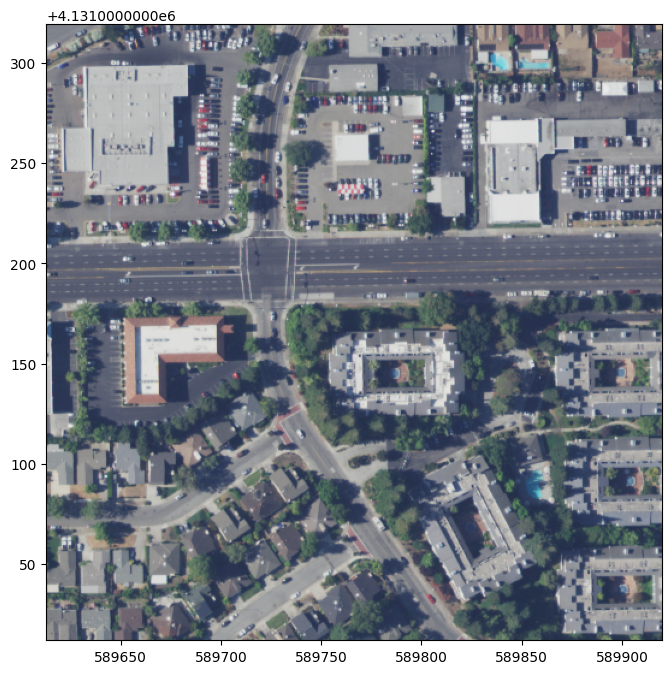

In [21]:
visualize_tile_only_year('m_3712141_nw_10_060_20180725_384', '2018')

<Figure size 640x480 with 0 Axes>

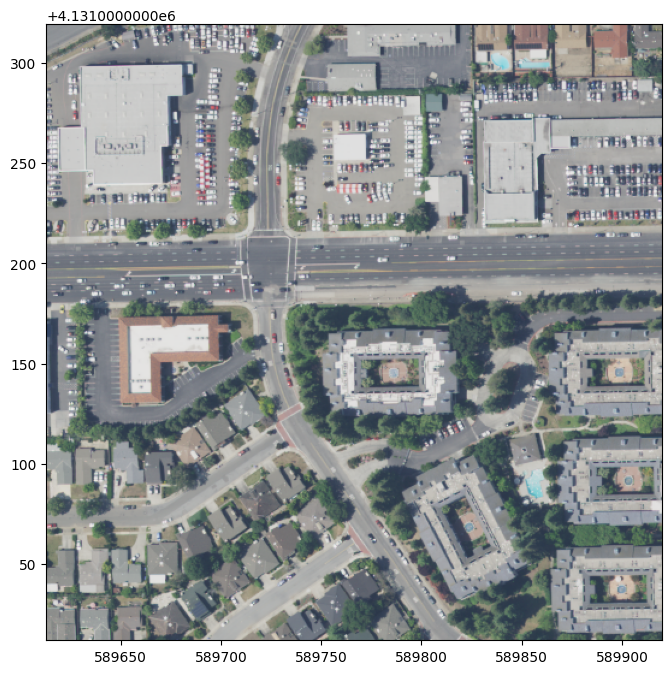

In [22]:
visualize_tile_only_year('m_3712141_nw_10_h_20160529_384', '2016')

<Figure size 640x480 with 0 Axes>

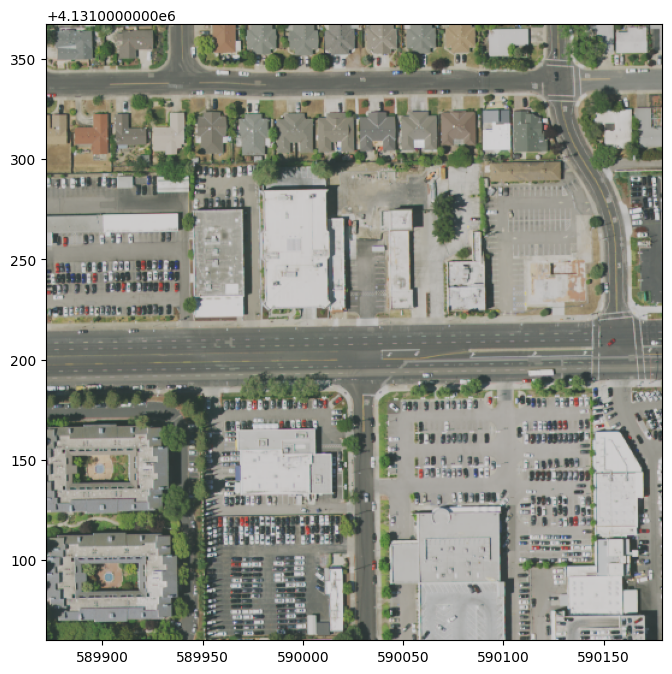

In [23]:
visualize_tile_only_year('m_3712141_nw_10_060_20200525_385', '2020')

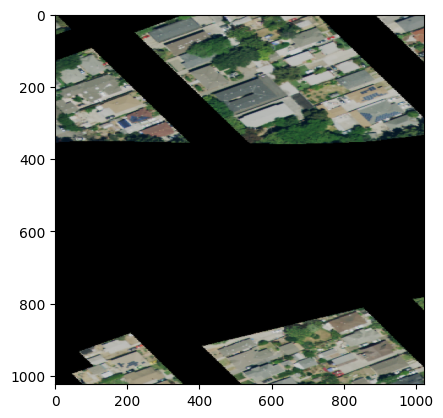

In [17]:
tile = 'm_3712141_ne_10_060_20200525_359'
x = np.load('/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/train/images/{}.npy'.format(tile))
plt.imshow(x)
plt.show()

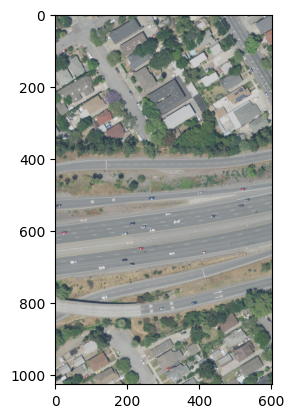

In [18]:
tile = 'm_3712141_ne_10_060_20200525_359'
x = np.load('/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/cf_tiles/{}_2016.npy'.format(tile))
plt.imshow(x)
plt.show()

## Visualize CBG-level and tile-level errors

In [12]:
cbg_footprints['b_n_resi'].hist()
plt.show()

KeyError: 'b_n_resi'

In [ ]:
tile_metrics_pd  = pd.read_csv(tile_metrics_fp)

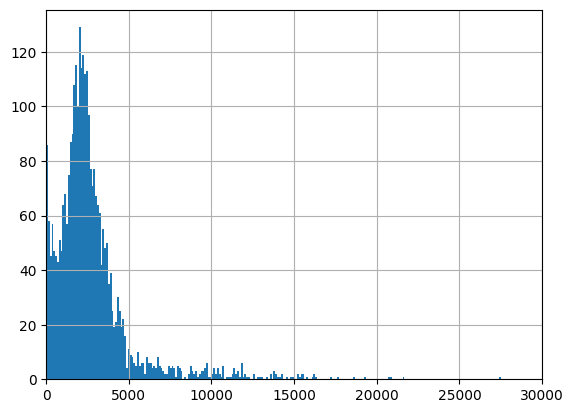

In [189]:
# NOTE: this figure is prior to correcting the post-processing pipeline
#tile_metrics_pd['false_pos_area'].hist(bins=250)
#plt.xlim([0, 30000])
#plt.show()

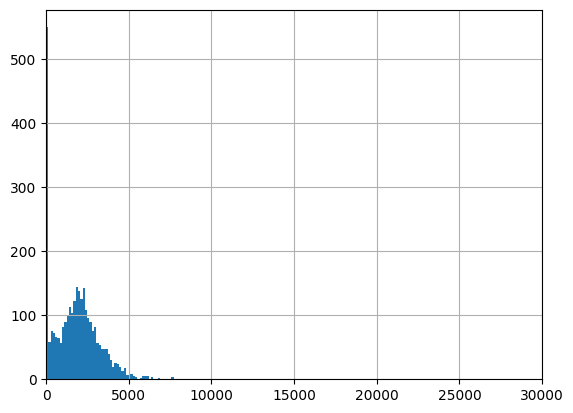

In [18]:
tile_metrics_pd['false_pos_area'].hist(bins=150)
plt.xlim([0, 30000])
#plt.ylim([0, 130])
plt.show()

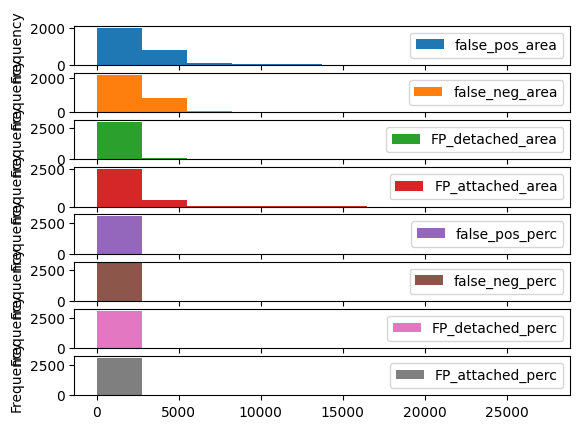

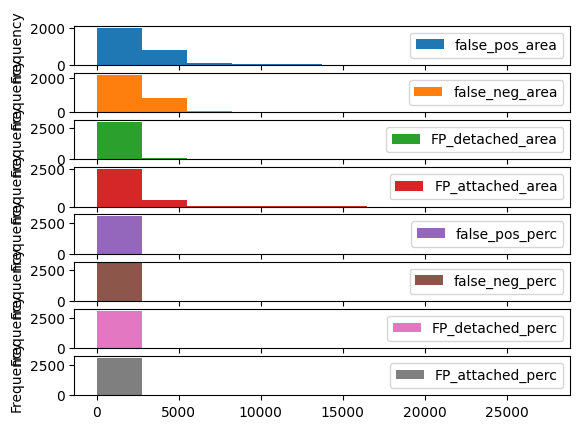

In [179]:
# Sample and visualize tiles with highest errors
tile_metrics_pd.plot.hist(subplots=True)
plt.show()

Geographic distribution of errors

false_pos_area


<Figure size 640x480 with 0 Axes>

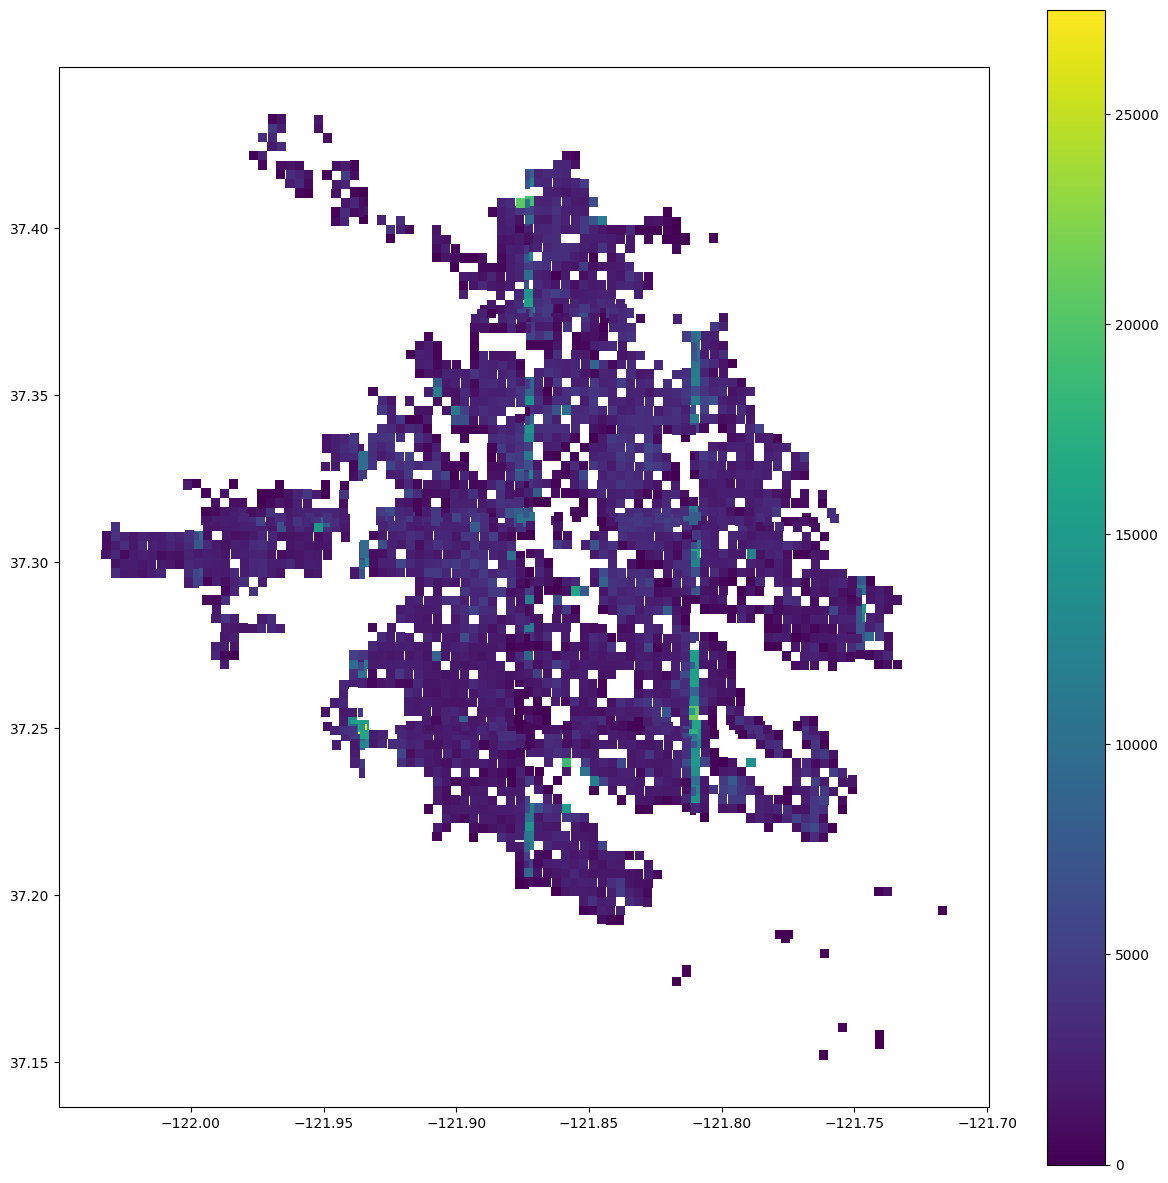

false_neg_area


<Figure size 640x480 with 0 Axes>

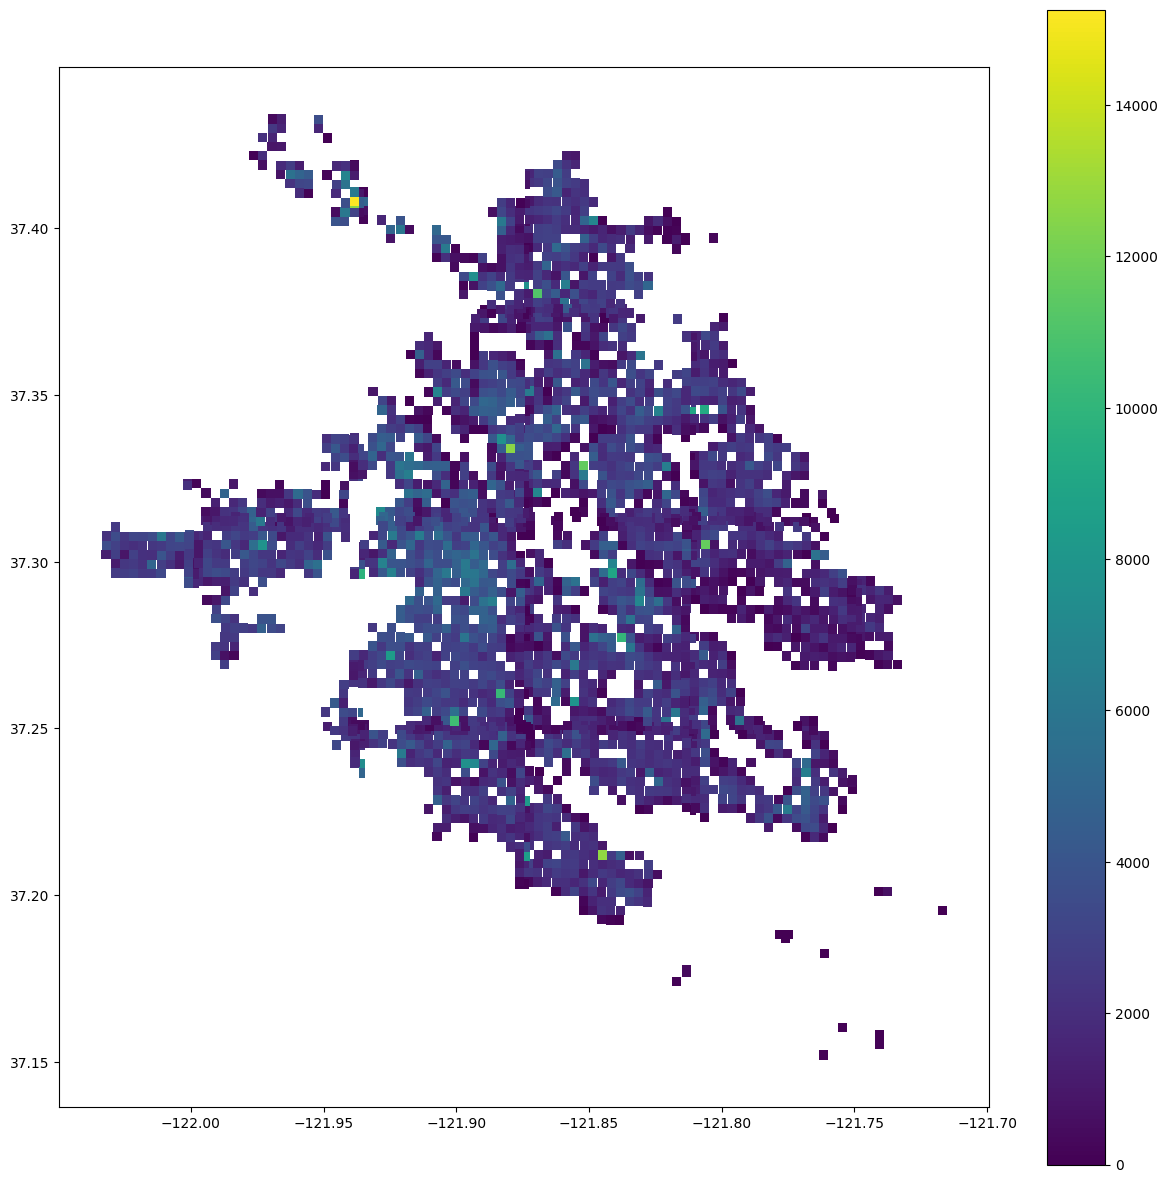

FP_detached_area


<Figure size 640x480 with 0 Axes>

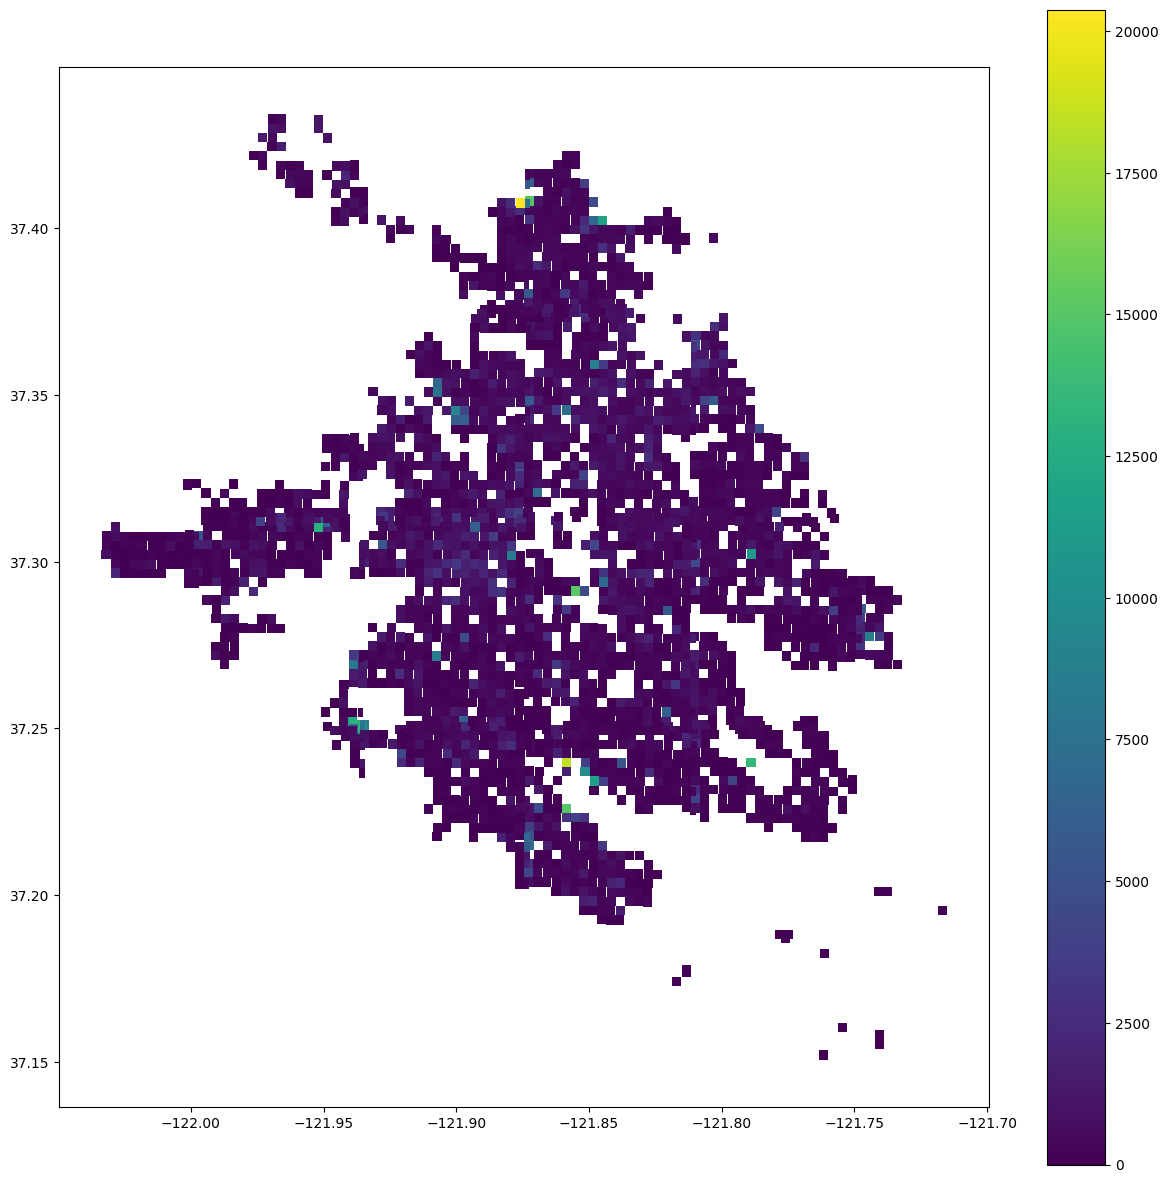

FP_attached_area


<Figure size 640x480 with 0 Axes>

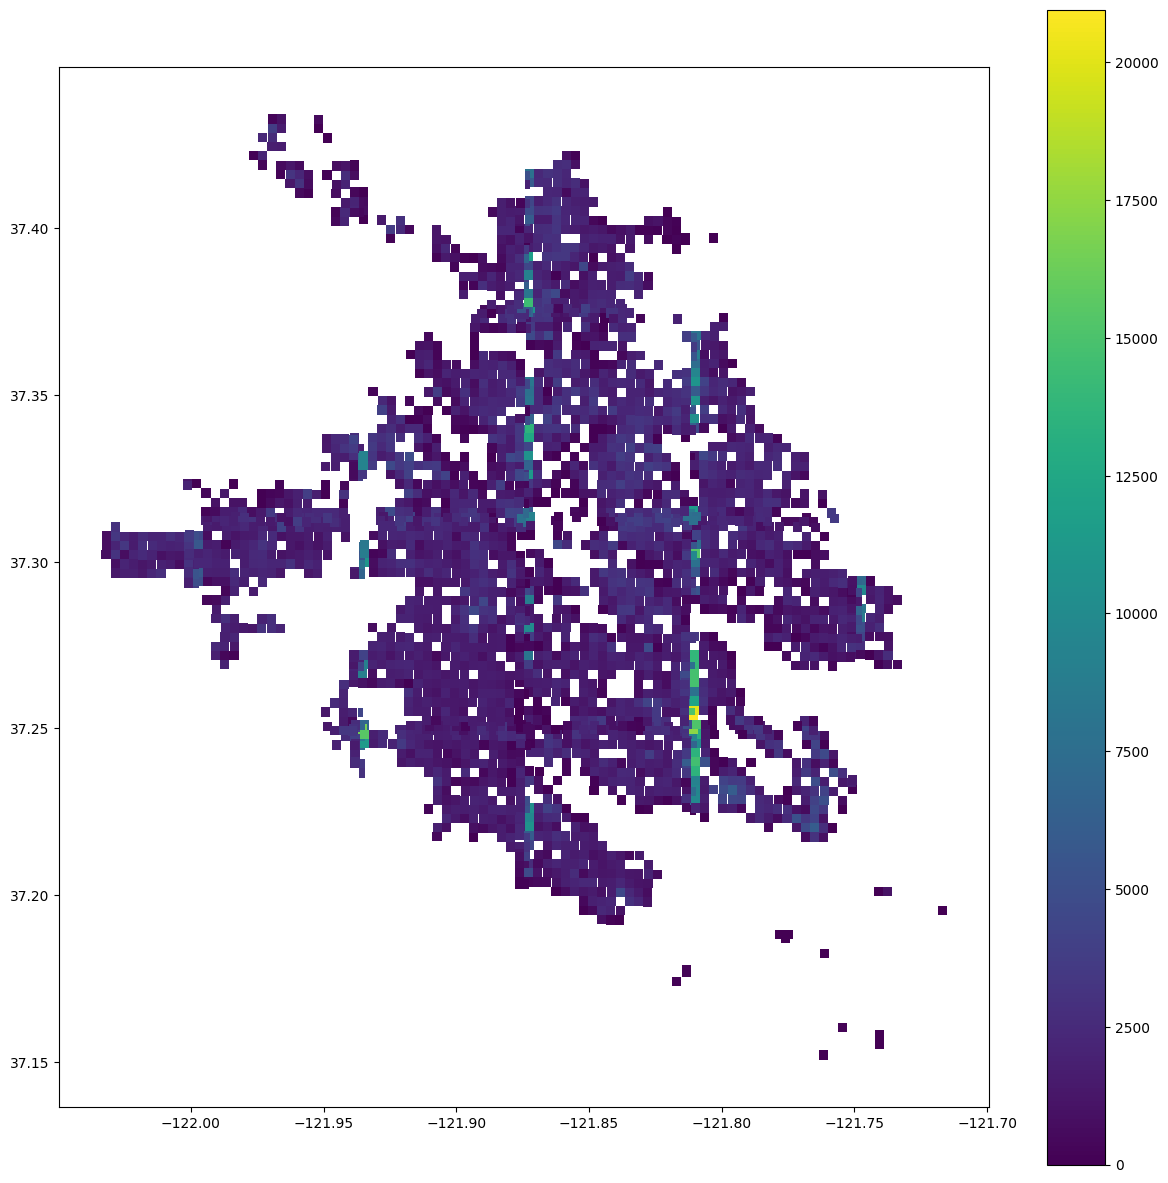

false_pos_perc


<Figure size 640x480 with 0 Axes>

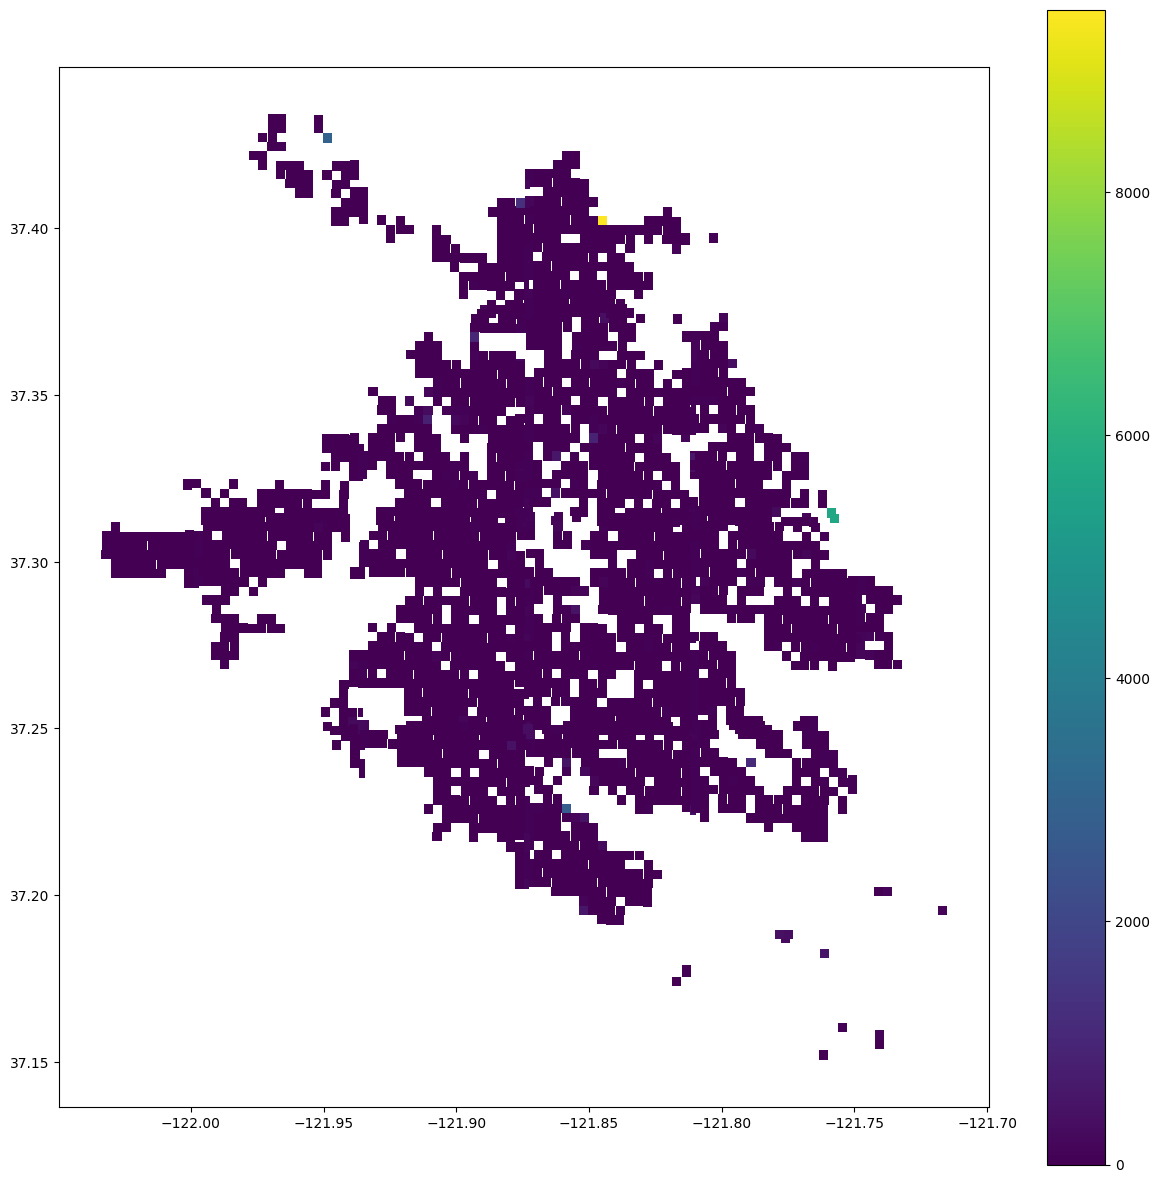

false_neg_perc


<Figure size 640x480 with 0 Axes>

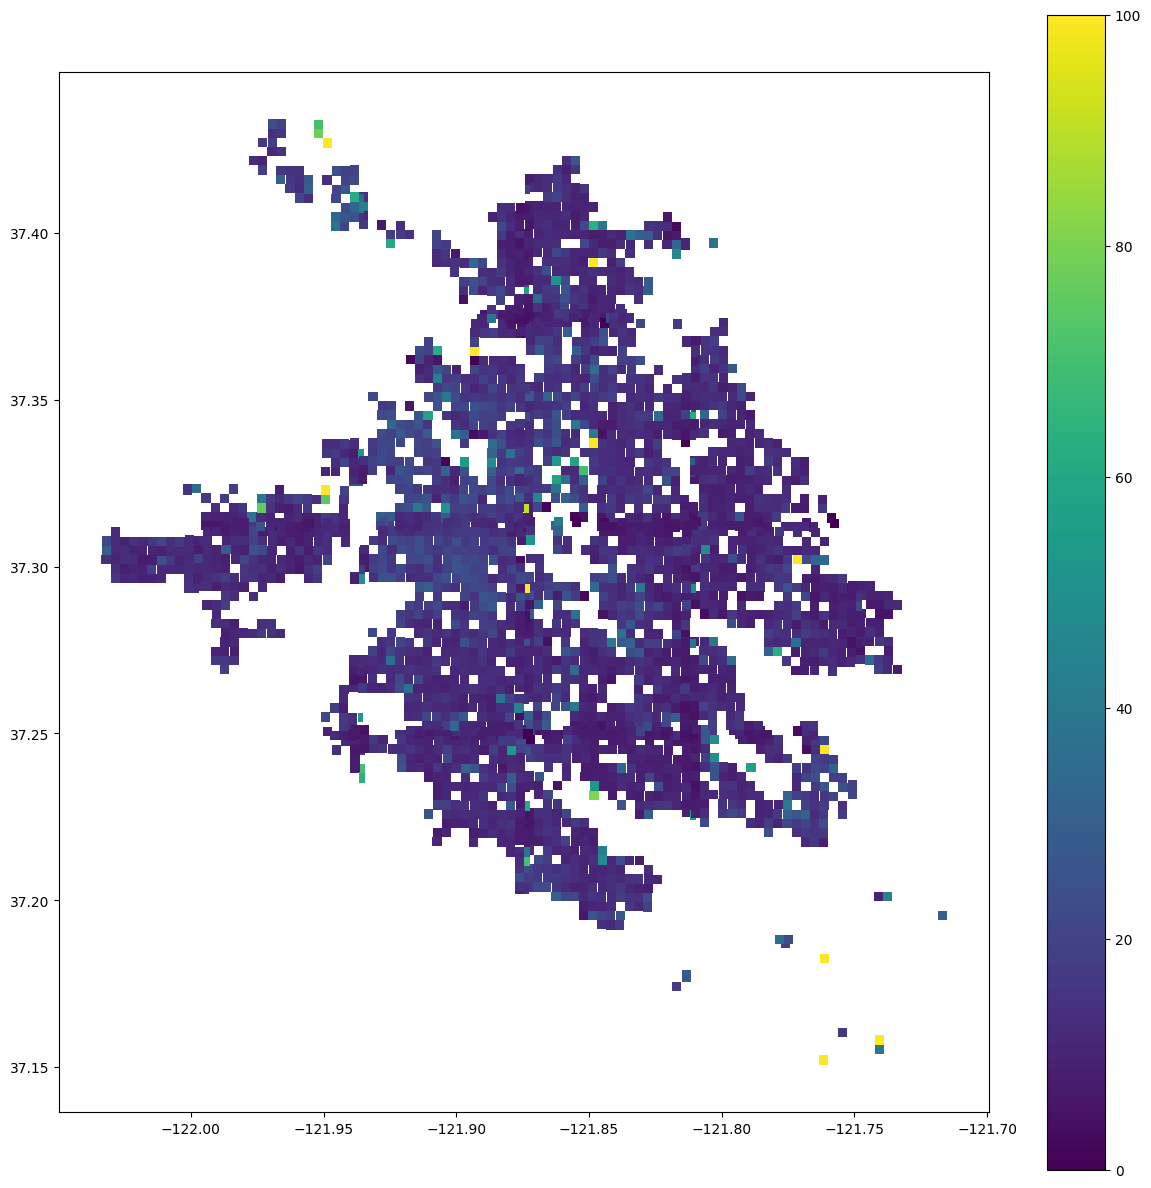

FP_detached_perc


<Figure size 640x480 with 0 Axes>

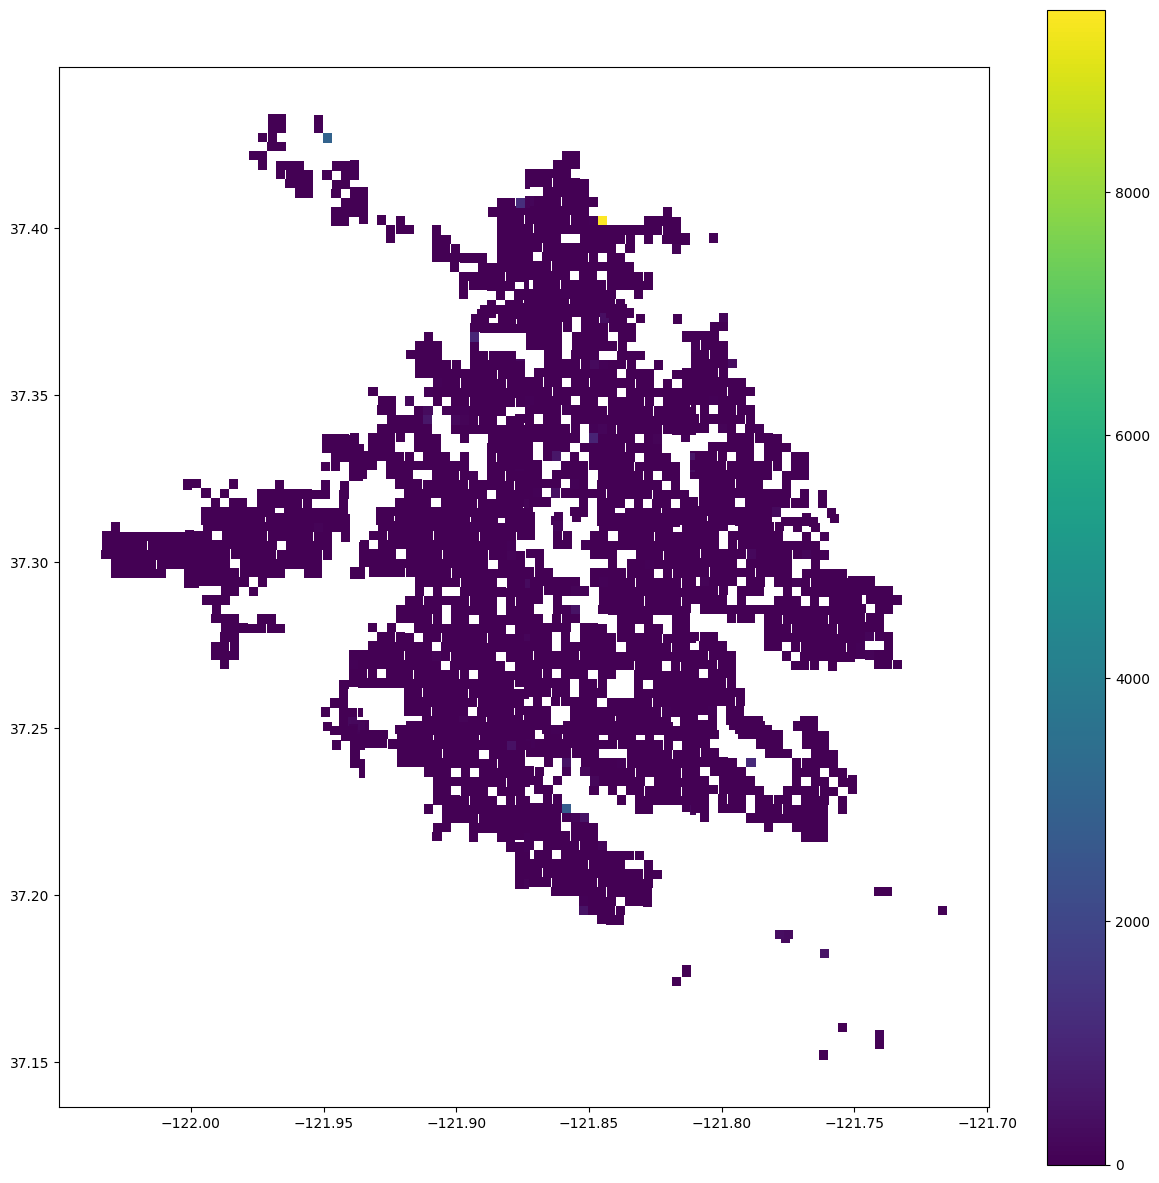

FP_attached_perc


<Figure size 640x480 with 0 Axes>

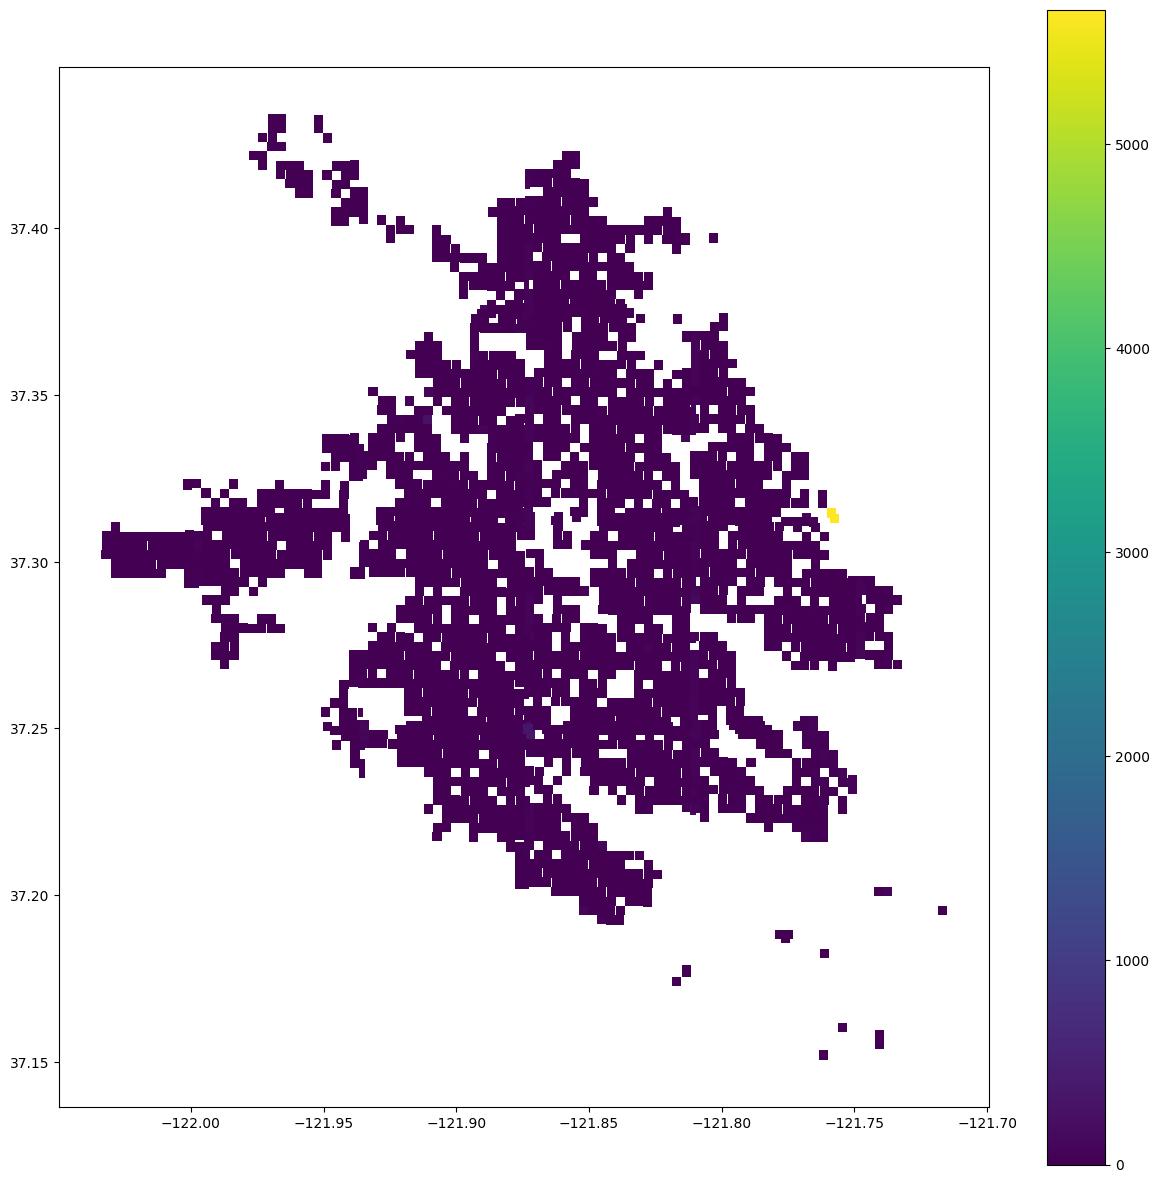

In [37]:
for col in ['false_pos_area', 'false_neg_area', 'FP_detached_area', 'FP_attached_area', 
            'false_pos_perc', 'false_neg_perc', 'FP_detached_perc', 'FP_attached_perc']:
    print(col)
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 15))
    tile_metrics_pd.plot(col, ax=ax, legend=True)
    plt.show()

<Figure size 640x480 with 0 Axes>

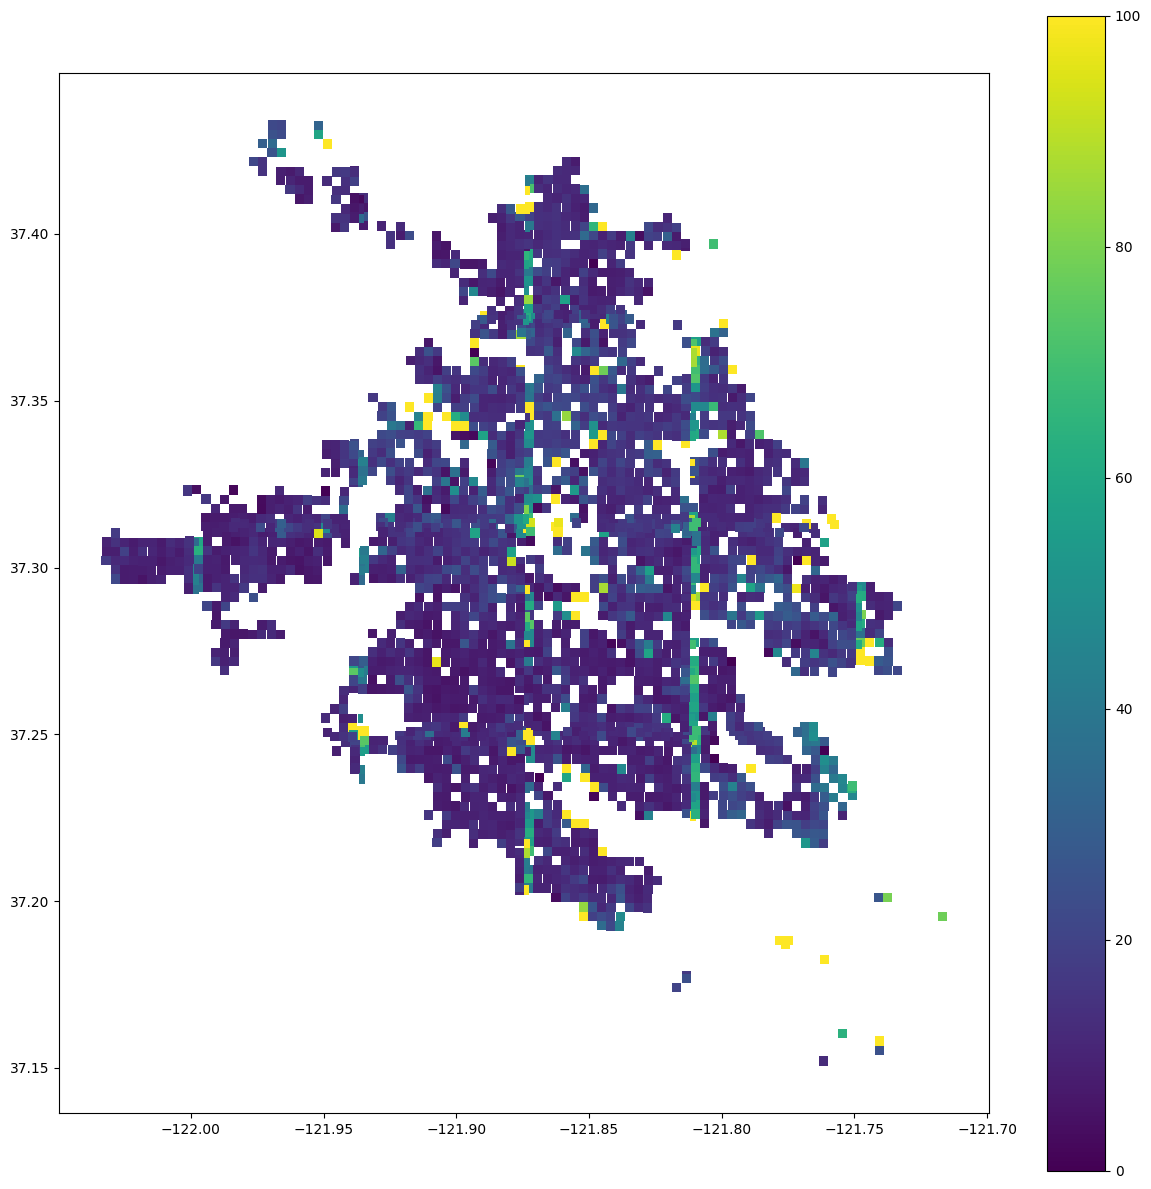

In [45]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
tile_metrics_pd.plot('false_pos_perc', ax=ax, legend=True, vmax=100)
plt.show()

In [43]:
tile_metrics_pd['false_pos_perc'].describe()

count    3072.000000
mean       33.401333
std       242.388739
min         0.000000
25%         9.716841
50%        13.289357
75%        20.622855
max      9500.692081
Name: false_pos_perc, dtype: float64

## Visualize sampled tiles

In [ ]:
file_name = 'm_3712149_ne_10_060_20200525_77'
tile_metrics = {file_name: tile_error}

# Visualize (sampled) tiles
def visualize_tile(tile_bounds_dict, tile_metrics, file_name, save=False):
    # Get image, OSM and inference
    img_file = None
    for dirname in ['train', 'val', 'test']:
        dirpath = os.path.join(IMG_FP, dirname, 'images', '{}.npy'.format(file_name))
        if os.path.exists(dirpath):
            img_file = dirpath
            
    tile_img = np.load(img_file)
    tile_bounds = get_bounds(tile_bounds_dict, file_name)
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    zoning_tile = gpd.clip(zoning, tile_bounds)
    
    # Get error masks
    false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)
    
    # Print metrics # TODO save these to the image --print coords?
    metrics = tile_metrics[file_name]
    for metric, metric_val in metrics.items():
        print('{}: {}'.format(metric, round(metric_val, 2)))
    
    # Plot
    fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    ax1.imshow(tile_img)
    osm_tile.plot(ax=ax2)
    infer_tile.plot(ax=ax2, alpha=0.4, color='red')
    zoning_tile.plot(ax=ax3, zorder=1)
    zoning_tile.plot(ax=ax4, zorder=1)
    FP_detached.plot(ax=ax3, zorder=2, color='red')
    FP_attached.plot(ax=ax4, zorder=2, color='red') 
    plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_FP, 'Error-Analysis', '{}.png'.format(file_name)), bbox_inches='tight')
    else:
        plt.show()

In [ ]:
visualize_tile(tile_bounds_dict=tile_bounds_dict, tile_metrics=tile_metrics, 
               file_name=file_name, save=False)

Choose OSM building area threshold

In [ ]:
tile_metrics_cbg.sort_values('osm_area', ascending=True).iloc[300:302]

/usr/local/lib/python3.8/dist-packages/rasterio/plot.py:107: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


<Figure size 640x480 with 0 Axes>

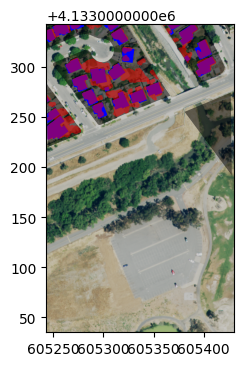

In [178]:
visualize_tile_full('m_3712142_nw_10_060_20200525_279')

# Playground

In [ ]:
# CHECK
tile_build_area = tile_metrics_cbg[['file', 'geometry']].sjoin(
    building_footprints_osm[['area', 'geometry']], predicate='intersects', how='right')

# GROUND TRUTH
visualize_tile_full('m_3712142_se_10_060_20200525_62')
fn = 'm_3712142_se_10_060_20200525_62'
tile_bounds = get_bounds(tile_bounds_dict, fn)
osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
osm_tile['area'].sum()

tile_build_area.loc[tile_build_area['file'] == 'm_3712142_se_10_060_20200525_62']['area'].sum()
tile_build_area = tile_build_area.groupby('file')['area'].sum().reset_index()
tile_build_area.loc[tile_build_area['file'] == 'm_3712142_se_10_060_20200525_62']['area']

tile_metrics_cbg.loc[tile_metrics_cbg['file'] == 'm_3712142_se_10_060_20200525_62']['area']

### Self-intersecting polygons

In [10]:
file_name = tiles[i]
tile_bounds = get_bounds(tile_bounds_dict, file_name)
infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
osm_tile = gpd.clip(building_footprints_osm, tile_bounds)

false_pos, false_neg, FP_detached, FP_attached = get_error_masks(infer_tile, osm_tile)

In [13]:
osm_tile

Empty GeoDataFrame
Columns: [index_left, GEOID, index, area, small, large, geometry]
Index: []

In [12]:
false_pos, false_neg, FP_detached, FP_attached

(Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 Empty GeoDataFrame
 Columns: [geometry]
 Index: [],
 Empty GeoDataFrame
 Columns: [geometry]
 Index: [])

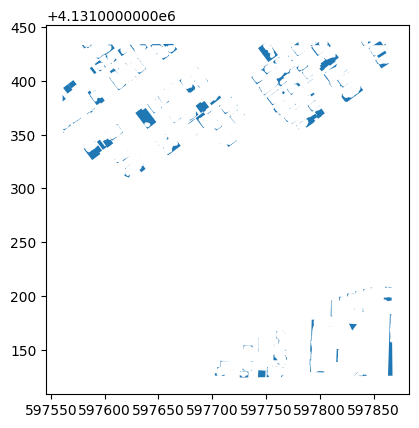

In [62]:
false_neg.to_crs('EPSG:26910').plot()
plt.show()

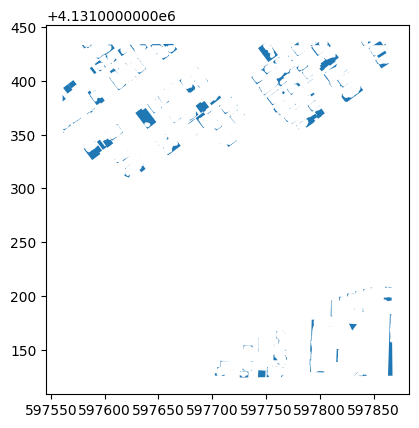

In [61]:
false_neg.to_crs('EPSG:26910').buffer(0.0000001).plot()
plt.show()

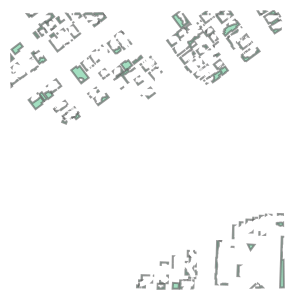

In [58]:
false_neg.to_crs('EPSG:26910').buffer(0.0000001).geometry.unary_union

In [53]:
x = false_neg[false_neg.to_crs('EPSG:26910').buffer(0.0001).geometry.is_valid == False].to_crs('EPSG:26910')

In [54]:
x

geometry
4   MULTIPOLYGON (((597807.562 4131436.084, 597810...
5   MULTIPOLYGON (((597796.873 4131435.959, 597796...
20  MULTIPOLYGON (((597637.748 4131429.300, 597637...
38  MULTIPOLYGON (((597657.408 4131344.886, 597657...

In [55]:
y = x.copy()
y.geometry.is_valid

4     False
5     False
20    False
38    False
dtype: bool

In [56]:
x.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

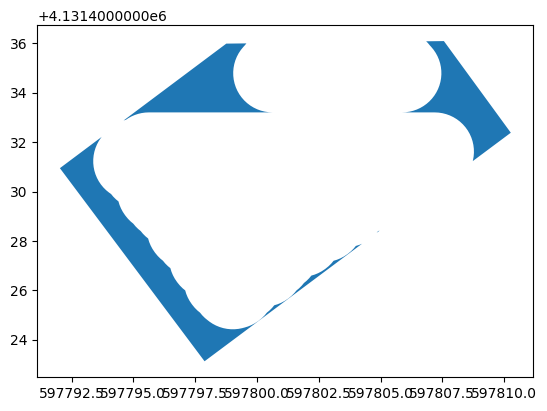

In [57]:
x.iloc[[0]].buffer(0.0000001).plot()
plt.show()

### Tile-level errors

In [11]:
file_name = 'm_3712149_ne_10_060_20200525_77'
tile_bounds = get_bounds(tile_bounds_dict, file_name)
infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
osm_tile = gpd.clip(building_footprints_osm, tile_bounds)

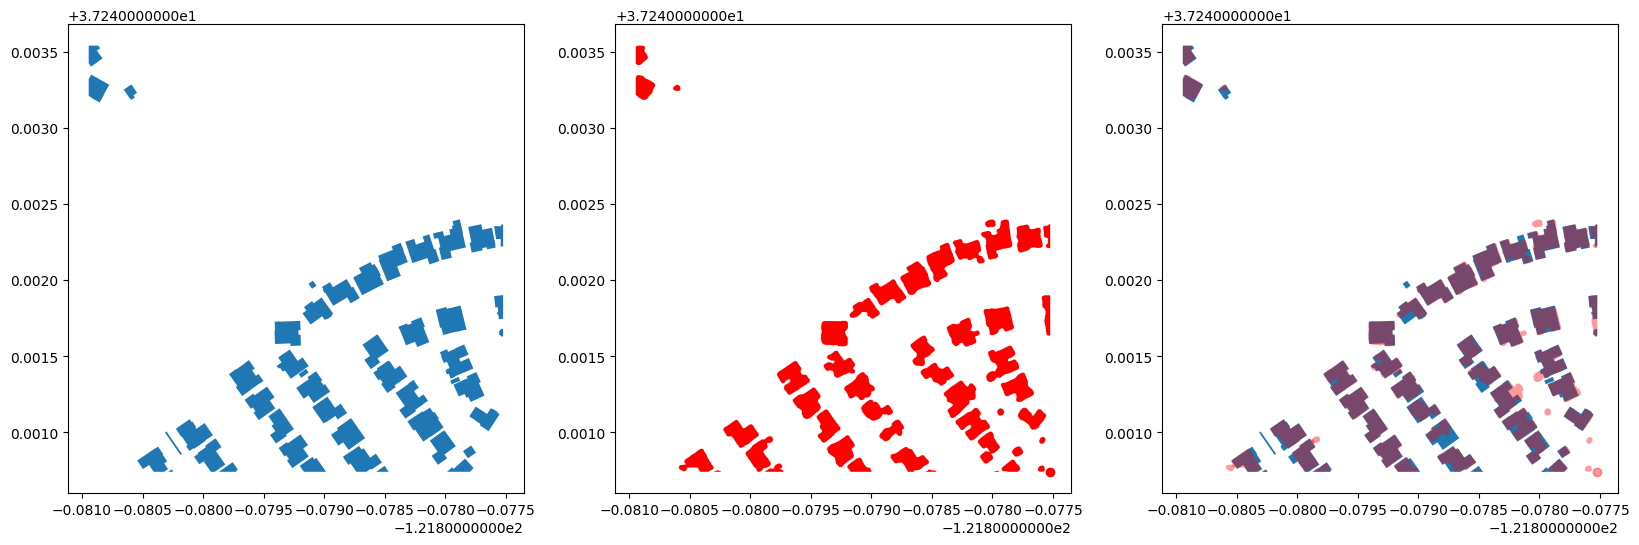

In [12]:
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
ax1 = osm_tile.plot(ax=ax1)
ax2 = infer_tile.plot(ax=ax2, color='red')
osm_tile.plot(ax=ax3)
infer_tile.plot(ax=ax3, alpha=0.4, color='red')
plt.show()

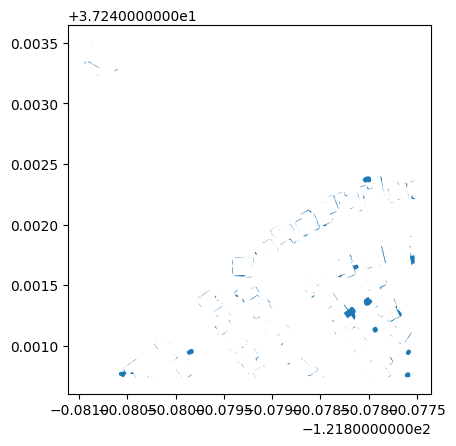

In [16]:
false_pos.plot()
plt.show()

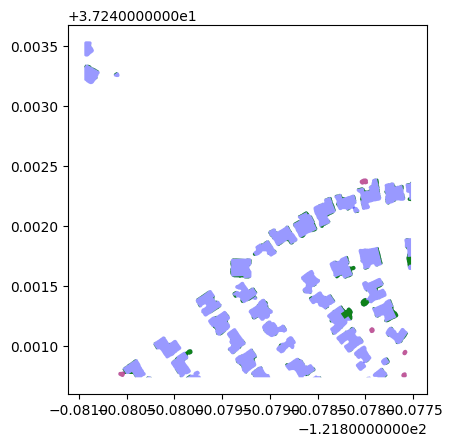

In [29]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
infer_tile.plot(ax=ax1, color='blue', alpha=0.4)
FP_detached.plot(ax=ax1, alpha=0.4, color='red')
FP_attached.plot(ax=ax1, alpha=0.9, color='green')
plt.show()

false_pos_area: 639.19
false_neg_area: 1157.86
FP_detached_area: 114.46
FP_attached_area: 524.73
false_pos_perc: 0.07
false_neg_perc: 0.12
FP_detached_perc: 0.01
FP_attached_perc: 0.05


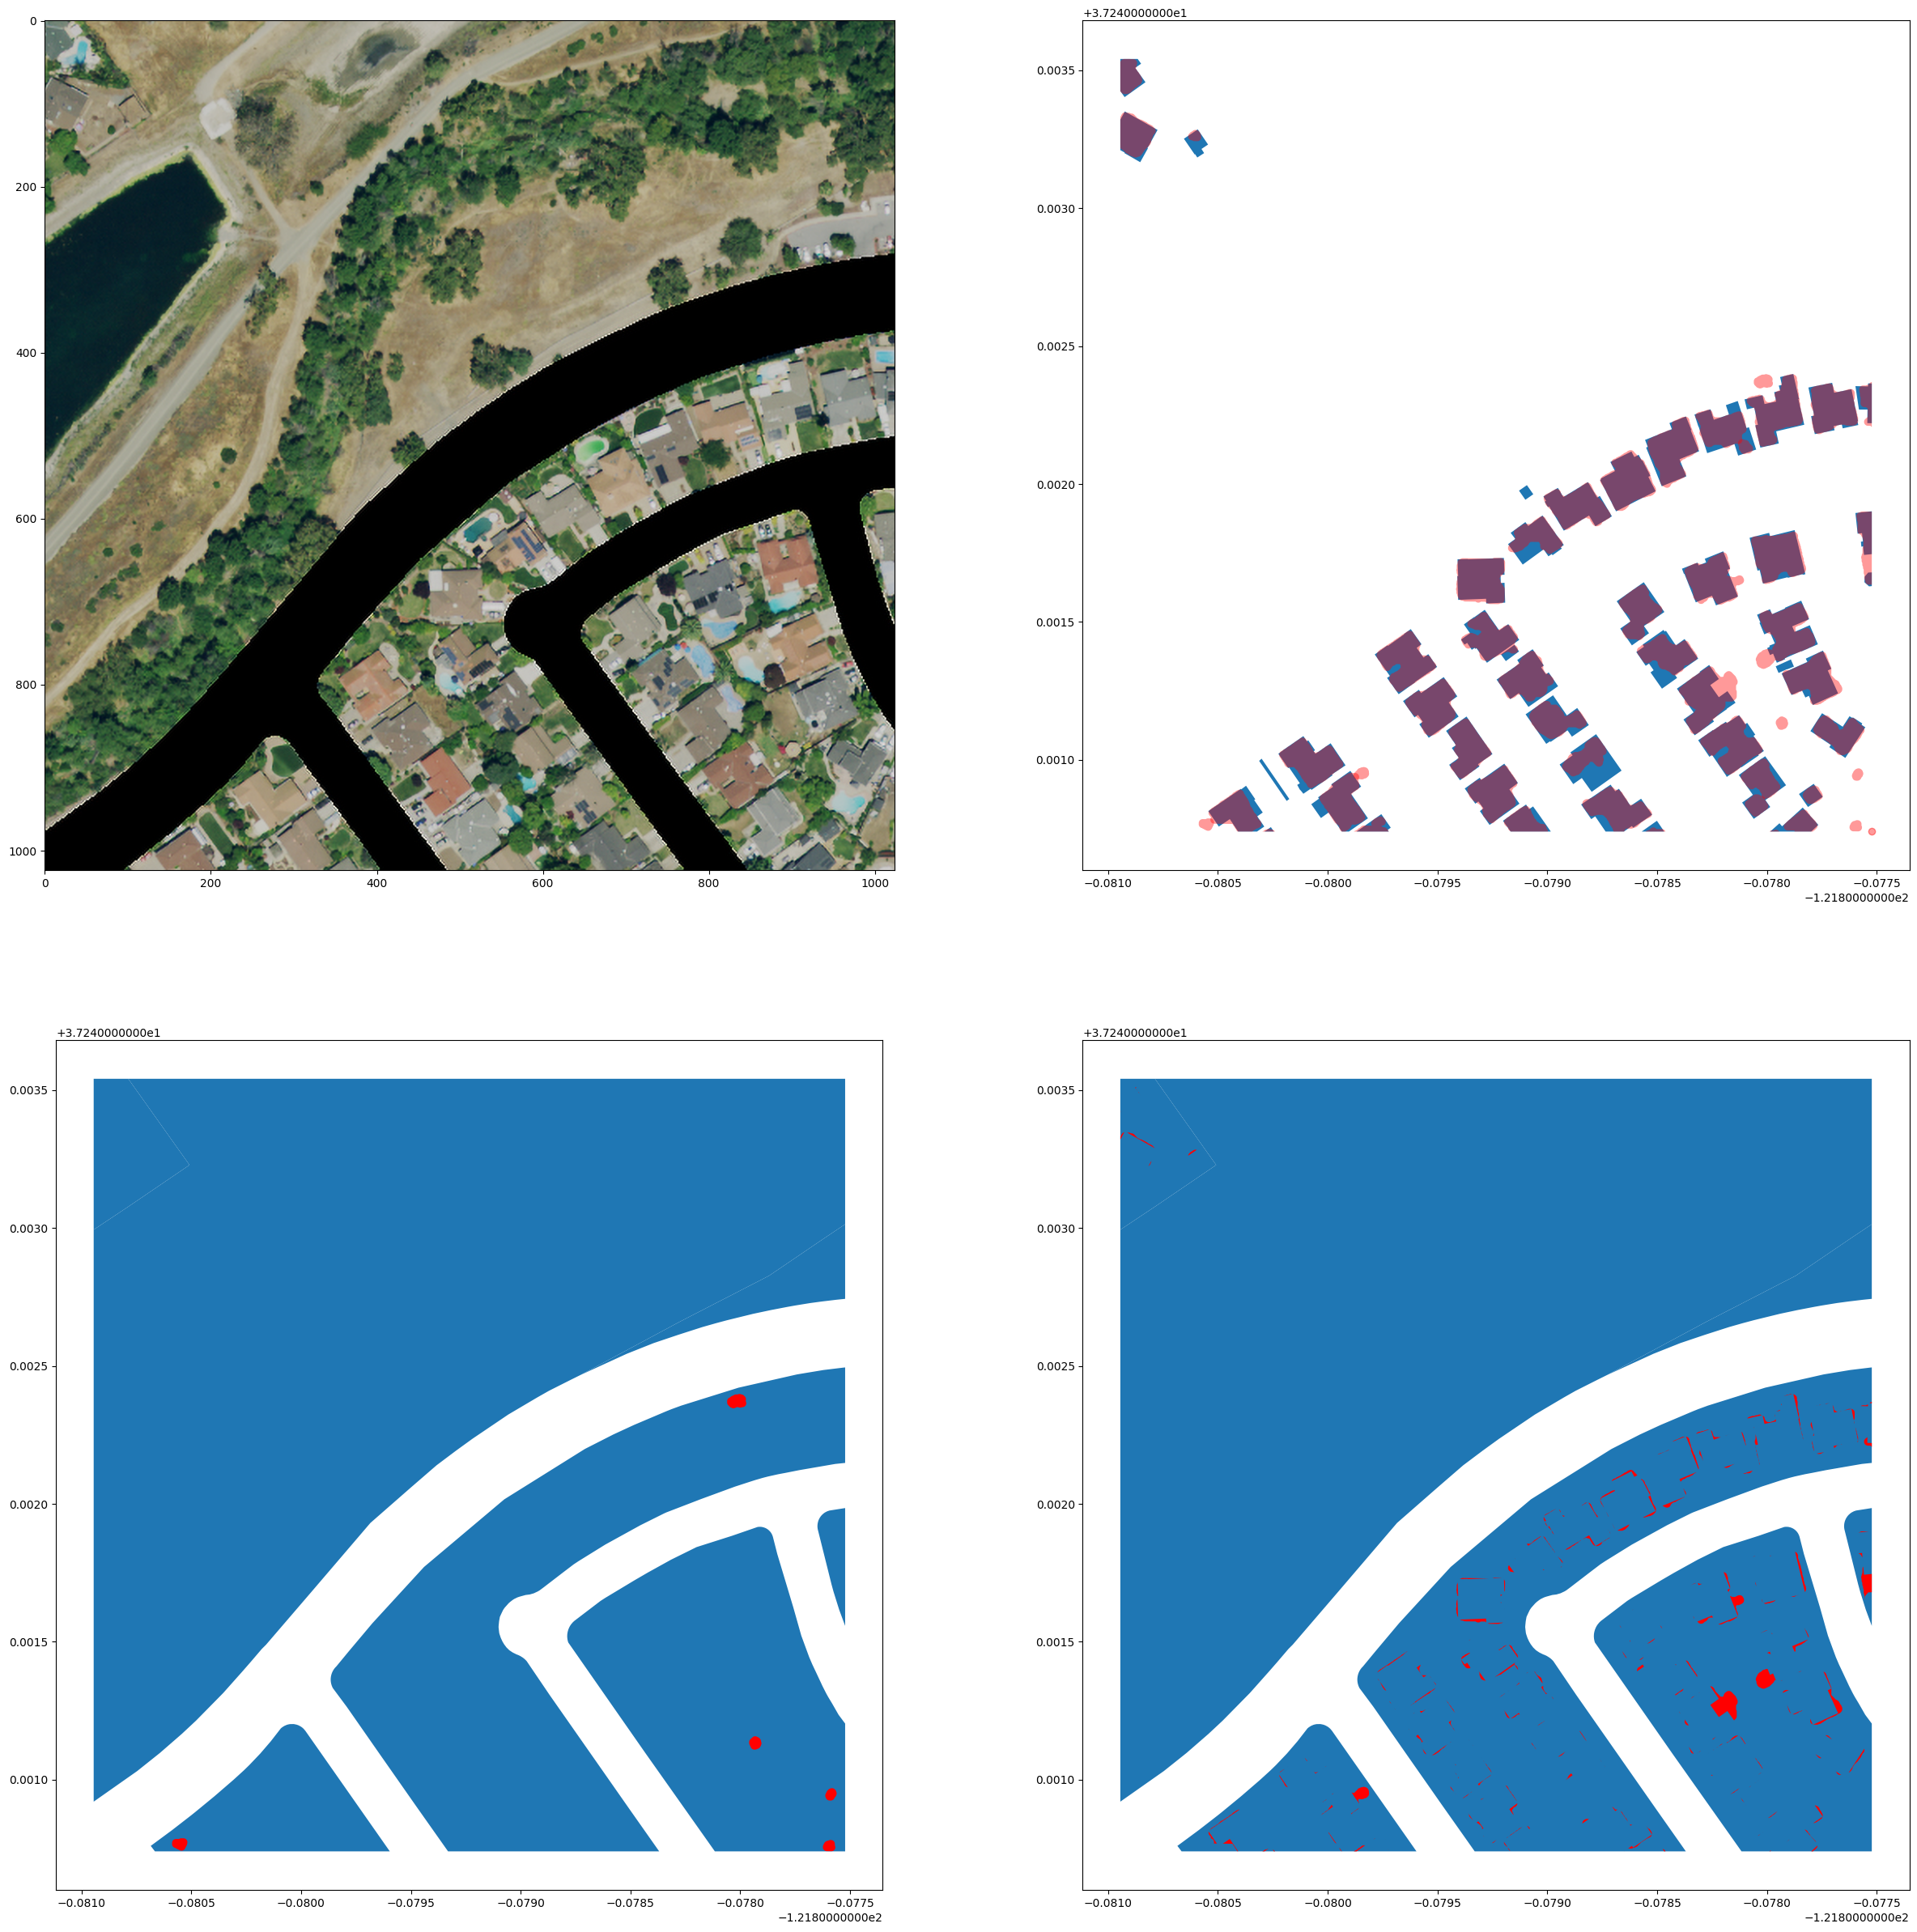